In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose   # para descomponer la serie temporal de precios en componentes de tendencia, estacionalidad y ruido.
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

import sys
import os

# IMPORTANTE - asegurarse de que el path es el correcto, tiene que apuntar a la carpeta Tools (o equivalente si se le cambia el nombre, debería ser Tools)

tools_path = os.path.abspath('./Tools')

# Comprobar si existe la carpeta Tools
if os.path.exists(tools_path):
    sys.path.append(tools_path)
else:
    print("The Tools directory does not exist. Please check the path.")
# importamos toolkit.py
try:
    from toolkit import procesar_datos_avocado  
    from toolkit import regresion_modelos
    from toolkit import formatear_resultados
except ImportError as e:  # Catch ImportError para ver si hay errores al importar
    print(f"ImportError: {e}. comprueba que 'process_dataset' exista en 'toolkit.py'.")


df=procesar_datos_avocado('./avocado.csv','B')
data_avo = df.copy()

data_avo['Date'] = pd.to_datetime(data_avo['Date'])
data_avo.info()
data_avo.describe().T.style.background_gradient(cmap='Blues')





<class 'pandas.core.frame.DataFrame'>
Index: 2704 entries, 312 to 18236
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    2704 non-null   int64         
 1   Date          2704 non-null   datetime64[ns]
 2   AveragePrice  2704 non-null   float64       
 3   Total Volume  2704 non-null   float64       
 4   4046          2704 non-null   float64       
 5   4225          2704 non-null   float64       
 6   4770          2704 non-null   float64       
 7   Total Bags    2704 non-null   float64       
 8   Small Bags    2704 non-null   float64       
 9   Large Bags    2704 non-null   float64       
 10  XLarge Bags   2704 non-null   float64       
 11  type          2704 non-null   object        
 12  year          2704 non-null   int64         
 13  region        2704 non-null   object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 316.9+ KB


,count,mean,min,25%,50%,75%,max,std
Unnamed: 0,2704.000000,24.236686,0.000000,10.000000,24.000000,38.000000,52.000000,15.486112
Date,2704,2016-08-14 00:00:00,2015-01-04 00:00:00,2015-10-25 00:00:00,2016-08-14 00:00:00,2017-06-04 00:00:00,2018-03-25 00:00:00,nan
AveragePrice,2704.000000,1.368569,0.620000,1.090000,1.360000,1.630000,2.580000,0.349636
Total Volume,2704.000000,2168912.789209,21986.870000,107203.890000,926201.430000,3904138.112500,11274749.110000,2396173.246051
4046,2704.000000,759961.626250,907.780000,9403.217500,93778.465000,1229129.002500,5160896.680000,1070172.133446
4225,2704.000000,745196.582249,2648.960000,32153.735000,209288.915000,1352607.065000,5402444.450000,912492.303837
4770,2704.000000,57757.096324,0.000000,97.945000,4382.895000,79841.482500,804558.250000,106629.679927
Total Bags,2704.000000,605991.413554,2485.950000,48353.787500,251564.165000,980059.907500,4145406.700000,722815.415041
Small Bags,2704.000000,459896.913561,1313.870000,29638.092500,221416.130000,736792.635000,3403581.490000,536894.436978
Large Bags,2704.000000,138159.872563,0.000000,7735.605000,35441.690000,138702.230000,2838239.390000,251639.273720


# 1.1 Descomposición de Series Temporales de Precios:
  ##  Analisis previo de los datos para determinar con cuales regiones trabajamos 

''' Para gran parte del proyecto utilizaremos regiones_geograficas mas California  
regiones_geograficas = ["California", "GreatLakes", "Midsouth", "Northeast", "Plains", "SouthCentral", "Southeast", "West"] ya 
que representan la suma del TotalUs y nos proporcinan una muestrare presentativa de los datos de US '''

 - Uso de Datos: Usa la columna AveragePrice y Date.
 - Esperado: Utiliza la función seasonal_decompose de la librería statsmodels para descomponer la serie temporal de precios en componentes de tendencia, estacionalidad y ruido.
 - Convierte Date a tipo datetime usando pd.to_datetime().
 - Agrupa los datos por Date y calcula el promedio de AveragePrice utilizando groupby() si es necesario.
 - Visualiza los componentes descompuestos usando matplotlib para cada uno de ellos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          169 non-null    datetime64[ns]
 1   AveragePrice  169 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB
#----------------------------------------------------------------------------------------------------


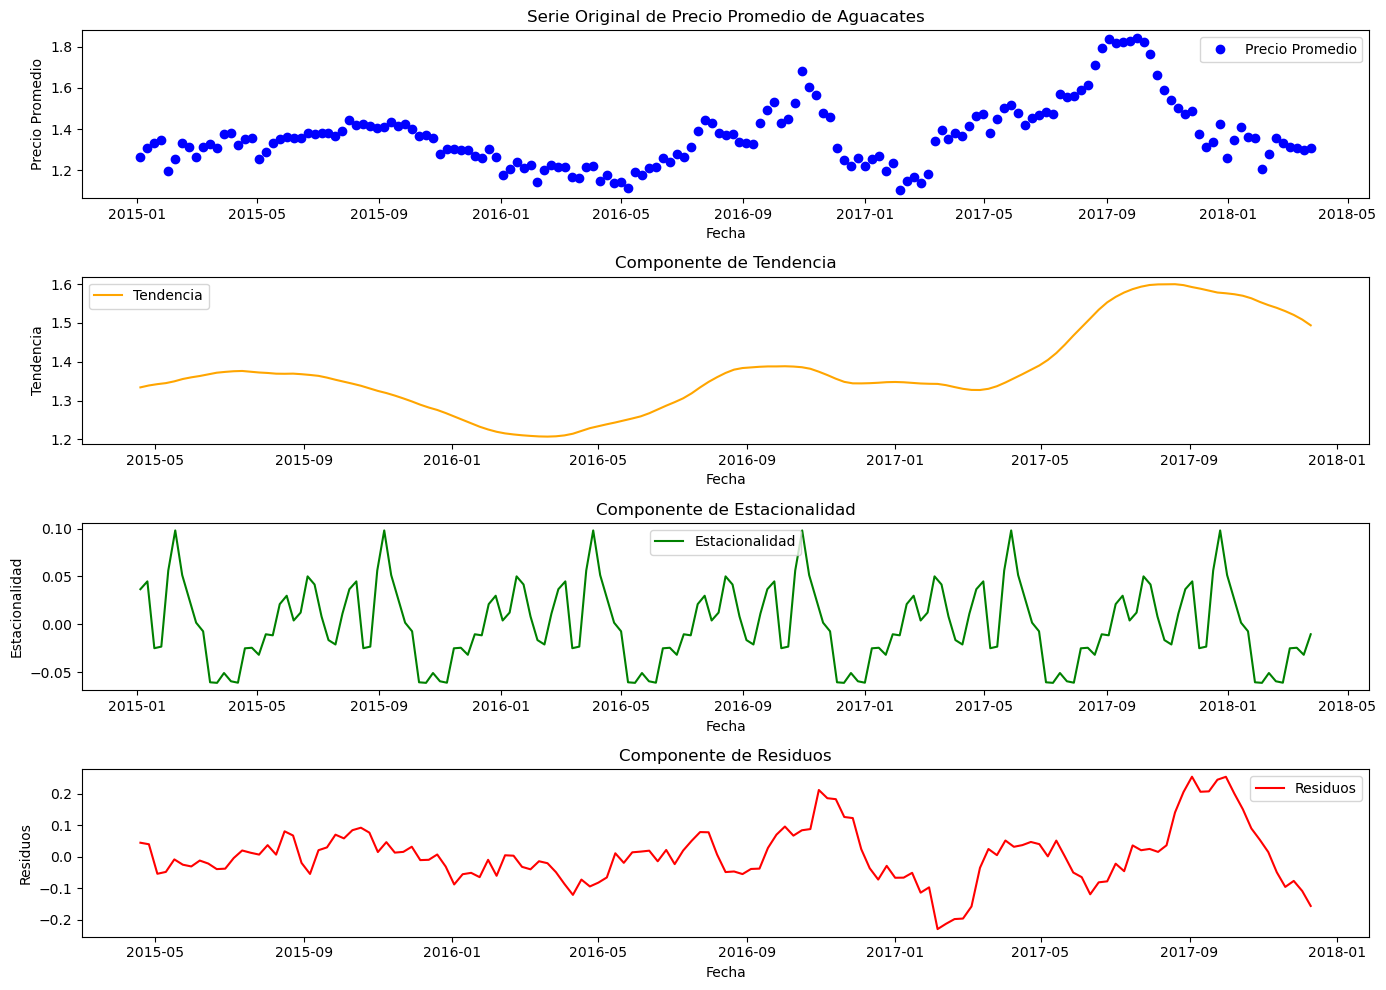

In [103]:
#1.1

data_avo['Date'] = pd.to_datetime(data_avo['Date'])
data_avo.dtypes 

promedio_precio = data_avo.groupby('Date')['AveragePrice'].mean().reset_index()
promedio_precio.info()

print("#"+ '-'*100) 
# Establecer Date como índice y especificar la frecuencia
promedio_precio.set_index('Date', inplace=True)


if promedio_precio['AveragePrice'].isnull().any():
    print("Valores nulos encontrados. Procediendo a manejarlos.")
    promedio_precio = promedio_precio.dropna()

# Descomponer la serie temporal en componentes de tendencia, estacionalidad y residuos.
result = seasonal_decompose(promedio_precio['AveragePrice'], model='additive',period=30)

# Crear gráficos para los componentes
plt.figure(figsize=(14, 10))

# Gráfico de la serie original
plt.subplot(4, 1, 1)
plt.plot(promedio_precio['AveragePrice'],marker='o', linestyle='', label='Precio Promedio', color='blue')
plt.title('Serie Original de Precio Promedio de Aguacates')
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio')
plt.legend()

# Gráfico de la tendencia
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia', color='orange')
plt.title('Componente de Tendencia')
plt.xlabel('Fecha')
plt.ylabel('Tendencia')
plt.legend()

# Gráfico de la estacionalidad
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad', color='green')
plt.title('Componente de Estacionalidad')
plt.xlabel('Fecha')
plt.ylabel('Estacionalidad')
plt.legend()

# Gráfico de los residuos
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuos', color='red')
plt.title('Componente de Residuos')
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.legend()

# Ajustar el layout
plt.tight_layout()
plt.show()


# 1.1. Conclusiones:
> El gráfico tendencia muestra un aumento continuo en los valores, el fenómeno está en crecimiento. 
> podría deberse a una mayor demanda o a una oferta limitada. 
> - Año 2016: Incremento de precios: Se registró un fenómeno en el que la popularidad del aguacate continuó subiendo, 
> impulsada por las tendencias de salud y bienestar, lo que se reflejó en un aumento de precios debido a la alta demanda.
> Problemas de suministro: Posibles dificultades climáticas en México y California pudieron impactar la oferta, provocando precios más altos. 
> - Año 2017: Escasez de oferta: En este año hubo una disminución notable en la producción mexicana debido a condiciones 
> climáticas adversas, esto impactó directamente en los precios en EE.UU., generando aumentos repentinos.
> Variabilidad mensual (baja estabilidad) debido a temporadas altas y bajas de consumo.


# 1.2. Análisis de Estacionalidad por Región:
 - Uso de Datos: Usa las columnas AveragePrice, Date y Total Volume.
 - Esperado: Utiliza gráficos de líneas para visualizar cómo varían los precios de aguacates por región a lo largo de diferentes estaciones del año.
 - Agrupa los datos por region y Date utilizando groupby().
 - Calcula el promedio de AveragePrice para cada región.
 - Representa gráficamente las tendencias utilizando plt.plot() de matplotlib.

AveragePrice    0
Total Volume    0
dtype: int64


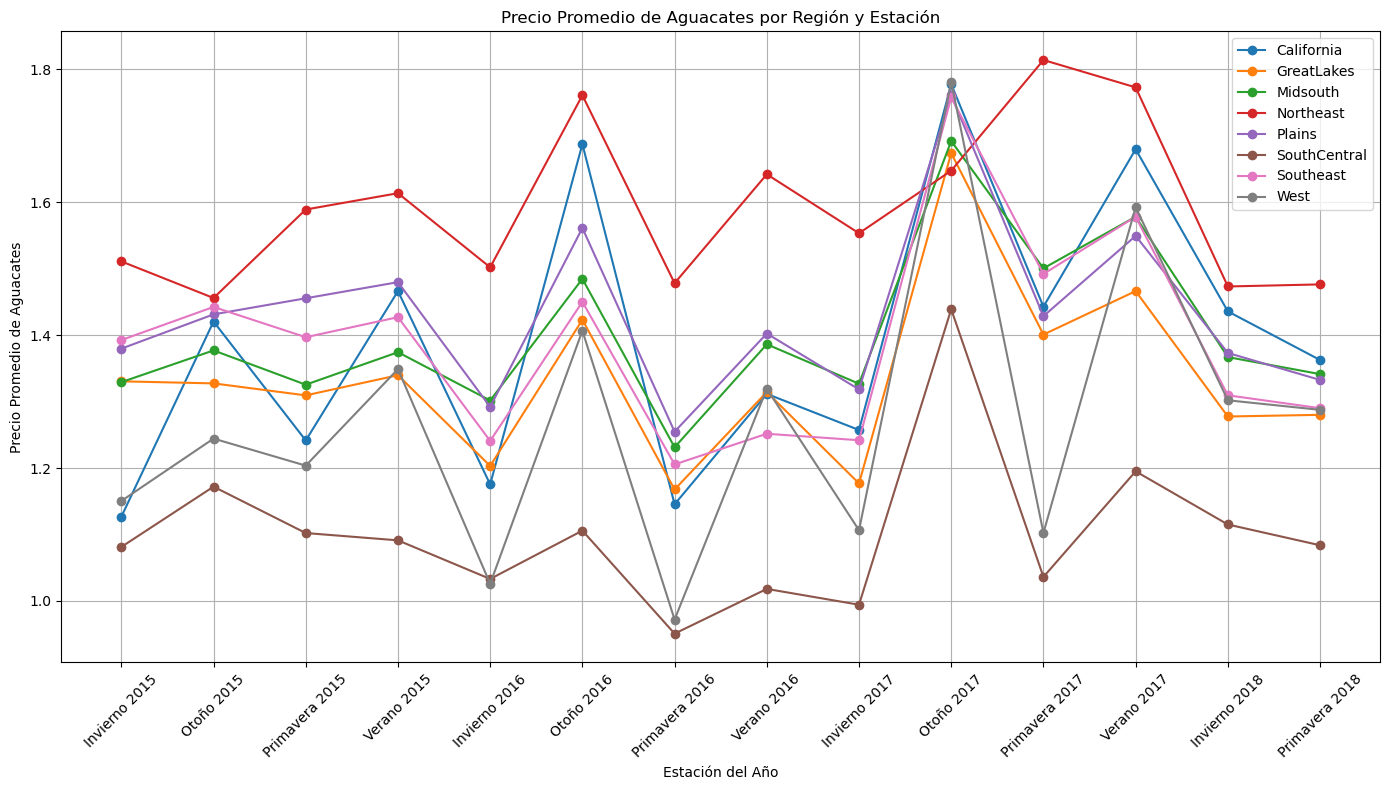

In [112]:
# Añadir una columna para la estación del año

def obtener_estacion(fecha):
    if fecha.month in [12, 1, 2]:
        return 'Invierno'
    elif fecha.month in [3, 4, 5]:
        return 'Primavera'
    elif fecha.month in [6, 7, 8]:
        return 'Verano'
    else:
        return 'Otoño'

# se crea nueva columna
data_avo = df.copy()
data_avo['Date'] = pd.to_datetime(data_avo['Date'])

data_avo['Estacion'] = data_avo['Date'].apply(obtener_estacion)


# Calcular el promedio de AveragePrice por región y estación
promedio_por_estacion = data_avo.groupby(['region','year', 'Estacion'])['AveragePrice'].mean().reset_index()


# Verificar si hay valores nulos en AveragePrice o Total Volume
print(data_avo[['AveragePrice', 'Total Volume']].isnull().sum())

# Calcular el promedio de 'AveragePrice' para cada región
promedio_precio_region = data_avo.groupby('region', as_index=False)['AveragePrice'].mean()


# Graficar los datos

# Graficar cada región con un color diferente

plt.figure(figsize=(14, 8))
for region, group in promedio_por_estacion.groupby('region'):
    group['Estacion'] = group['Estacion'] + ' ' + group['year'].astype(str)
    plt.plot(group['Estacion'], group['AveragePrice'], label=region, marker='o')

# Añadir títulos y etiquetas
plt.title('Precio Promedio de Aguacates por Región y Estación')
plt.xlabel('Estación del Año')
plt.ylabel('Precio Promedio de Aguacates')
plt.xticks(rotation=45)  # rotar las etiquetas del eje x
plt.legend()
plt.grid()
plt.tight_layout()  # Ajustar el diseño para que no se corten los elementos

# Mostrar el gráfico
plt.show()

1.3. **Comparación de Precios Promedio Mensuales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Date`.
   - **Esperado:** Calcula y compara los precios promedio mensuales.
     - Agrupa los datos por mes usando `pd.Grouper` con `freq='M'`.
     - Calcula el promedio de `AveragePrice` para cada mes con `mean()`.
     - Visualiza los resultados con un gráfico de líneas usando `plt.plot()`.

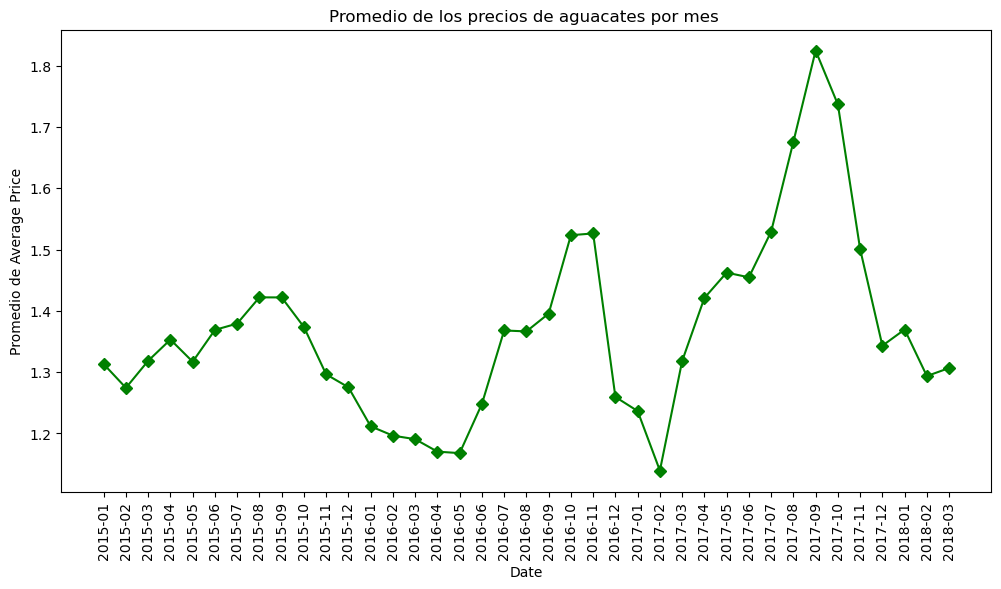

In [8]:
#1.3 agrupar por mes

#data_avo['type'] = pd.to_numeric(df['type'], errors='coerce') 
df_monthly = data_avo.groupby(pd.Grouper(key='Date', freq='ME'))['AveragePrice'].mean().reset_index()

df_monthly['Mes_Ano']= df_monthly['Date'].dt.to_period('M').astype(str)
# Grafica
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['Mes_Ano'],df_monthly['AveragePrice'], marker='D', linestyle='-', color='g')

plt.xlabel('Date')
plt.ylabel('Promedio de Average Price')
plt.title('Promedio de los precios de aguacates por mes ')
plt.xticks(rotation=90)
plt.show()

1.4. **Tendencia de Ventas a lo Largo del Tiempo:**
   - **Uso de Datos:** Usa las columnas `Total Volume` y `Date`.
   - **Esperado:** Analiza cómo varía el volumen total de ventas a lo largo del tiempo.
     - Agrupa los datos por `Date` y suma el `Total Volume` usando `groupby()`.
     - Visualiza los resultados usando un gráfico de líneas con `plt.plot()` para mostrar la tendencia.

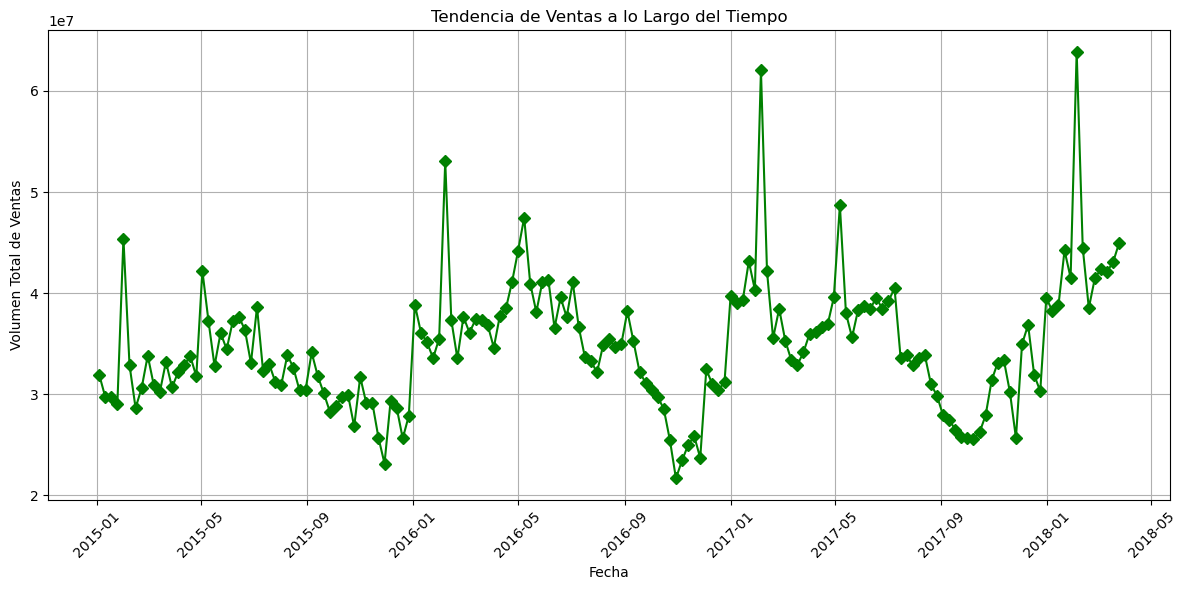

In [10]:
# 1.4 
# Agrupar por fecha y sumar el volumen total
data_avo = df.copy()
data_avo['Date'] = pd.to_datetime(data_avo['Date'])
ventas_por_fecha = data_avo.groupby('Date')['Total Volume'].sum().reset_index()

# Visualizar la tendencia de ventas a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(ventas_por_fecha['Date'], ventas_por_fecha['Total Volume'], marker='D',color='g')
plt.title('Tendencia de Ventas a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Volumen Total de Ventas')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# 1.4 Interpretación de los Resultados

La tendencia general de ventas de aguacates muestra un **ligero crecimiento a lo largo del tiempo**.

### Picos de Ventas
Cada año, en el mes de **febrero** se alcanza un pico máximo de ventas de aguacates. Después de este punto, las ventas se corrigen durante los primeros cinco meses, alcanzando un valor cercano al máximo nuevamente en el quinto mes. Al observar que estos picos ocurren consistentemente en el mismo periodo, es posible que exista un evento específico que impulse el consumo de aguacates de manera extraordinaria en febrero.

Una hipótesis probable es que este aumento en ventas podría estar relacionado con la **Super Bowl en Estados Unidos**, evento en el que el consumo de guacamole, y por ende de aguacates, tiende a aumentar significativamente.

### Valles de Ventas
También se observa que los **peores resultados en ventas** se concentran en los últimos tres meses de cada año. Estos "valles" en el volumen total de ventas reflejan los puntos más bajos y se repiten de manera constante en este periodo. Esto podría estar relacionado con una disminución en la demanda de los consumidores o con la finalización de la temporada de cosecha del aguacate, lo que afecta la oferta disponible en el mercado.

### Estacionalidad en los Datos
Dado que tanto los picos como los valles de ventas se presentan en los mismos periodos año tras año, se puede afirmar que hay **estacionalidad en los datos**. Algunos ejemplos específicos de esta estacionalidad son:
- **Meses de verano**: Durante esta temporada, se percibe una tendencia al alza en las ventas, aunque sin alcanzar el pico máximo observado en febrero.
- **Septiembre a Diciembre**: Este periodo muestra consistentemente los valores de ventas más bajos en cada año, lo que podría explicarse por una reducción en la demanda por parte de los consumidores, junto con el fin de la época de cosecha.


1.5. **Análisis de Cambios en Precios Anuales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `year`.
   - **Esperado:** Observa las diferencias anuales en los precios promedio.
     - Agrupa los datos por `year` utilizando `groupby()`.
     - Calcula el promedio de `AveragePrice` para cada año.
     - Representa los resultados en un gráfico de barras usando `plt.bar()` que compare los precios de cada año.

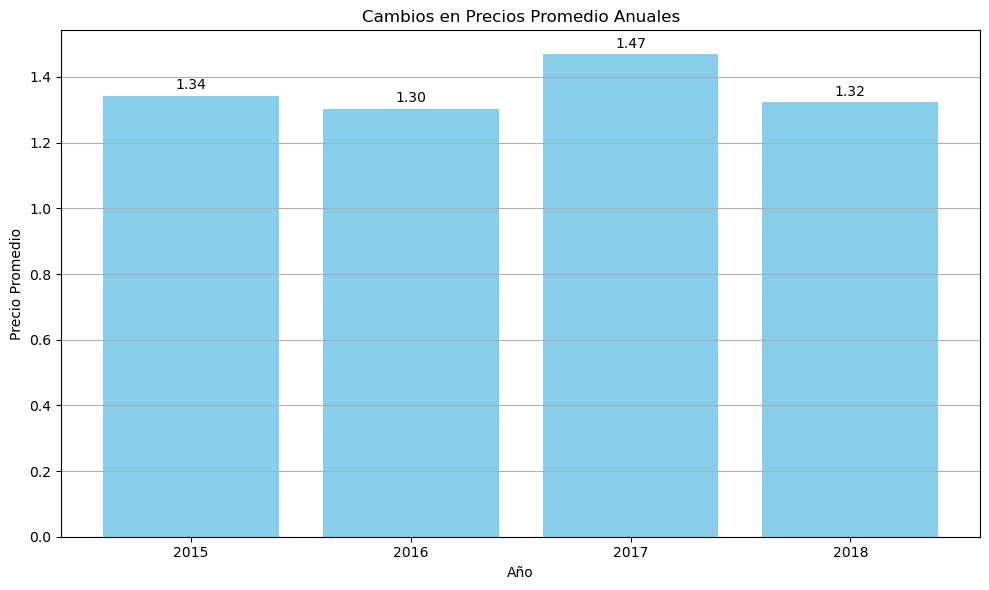

In [13]:
# 1.5 Extraer el año de la columna 'Date'

data_avo['year'] = data_avo['Date'].dt.year
# Agrupar por año y calcular el promedio de precios
precios_anuales = data_avo.groupby('year')['AveragePrice'].mean().reset_index()
# Visualizar los cambios en precios anuales
plt.figure(figsize=(10, 6))
plt.bar(precios_anuales['year'], precios_anuales['AveragePrice'], color='skyblue')
plt.title('Cambios en Precios Promedio Anuales')
plt.xlabel('Año')
plt.ylabel('Precio Promedio')
plt.xticks(precios_anuales['year'])
plt.grid(axis='y')

# Añadir el precio como etiqueta en cada barra
for i, v in enumerate(precios_anuales['AveragePrice']):
    plt.text(precios_anuales['year'][i], v + 0.02, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

# Análisis de los Precios Promedio Anuales de Aguacates (2015-2018)
- Al observar cómo han cambiado los precios promedio de los aguacates entre 2015 y 2018, podemos aprender cómo entender los datos y 
qué factores pueden estar detrás de las fluctuaciones de precios en productos agrícolas. Este análisis puede ayudar a practicar técnicas básicas de visualización y sacar conclusiones, aunque simples, sobre los datos.

## 1. Patrón General de Precios
    
- Análisis año por año, se ven algunos patrones interesantes:
- **2015 y 2016**: En estos dos años, el precio promedio anual del aguacate se mantuvo bastante estable, alrededor de $1.34-$1.38. Esta estabilidad puede deberse a una situación equilibrada entre la oferta (cuántos aguacates están disponibles en el mercado) y la demanda (cuánta gente quiere comprarlos).
- **2017**: Este año muestra un cambio notable, con el precio promedio subiendo a $1.52. Un aumento como este podría indicar que hubo una menor oferta (quizás debido a problemas en las cosechas), un aumento en la demanda o ambos.
- **2018**: Después del aumento en 2017, el precio promedio baja ligeramente a $1.35. Esto podría ser un ajuste donde la oferta del mercado volvió a satisfacer la demanda de manera más eficiente.

## 2. Factores que Podrían Afectar el Precio
Para entender por qué los precios pueden subir o bajar, es importante considerar algunos factores comunes:
- **Oferta y Demanda**: Si el aguacate se hace más popular (como ha sucedido en Estados Unidos y Europa), la demanda sube, y esto puede aumentar los precios, especialmente si la oferta no crece al mismo ritmo.
- **Clima y Agricultura**: Factores como el clima o enfermedades en los cultivos pueden afectar cuántos aguacates se producen. Si un año tiene sequías o inundaciones, la producción baja y el precio puede subir.
- **Ciclos de Producción**: Los aguacates pueden tener años buenos y malos debido a factores naturales. Estos ciclos afectan el precio si las cosechas son muy distintas de un año a otro.





# 2.1 Gráfico de Violín de Volumen de Ventas por Región:

 - Uso de Datos: Usa las columnas Total Volume y region.
 - Esperado: Visualiza la distribución de ventas en diferentes regiones.
 - Utiliza la función violinplot de seaborn para crear gráficos de violín.
 - Configura los ejes para mostrar la relación entre Total Volume y region.
 - Añade etiquetas y títulos usando plt.title() y plt.xlabel() para facilitar la interpretación.

C:\Users\chris\AppData\Local\Temp\ipykernel_5936\1695020838.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='region', y='Total Volume', data=data_avo,palette='Set1')  # ,inner='quartile'


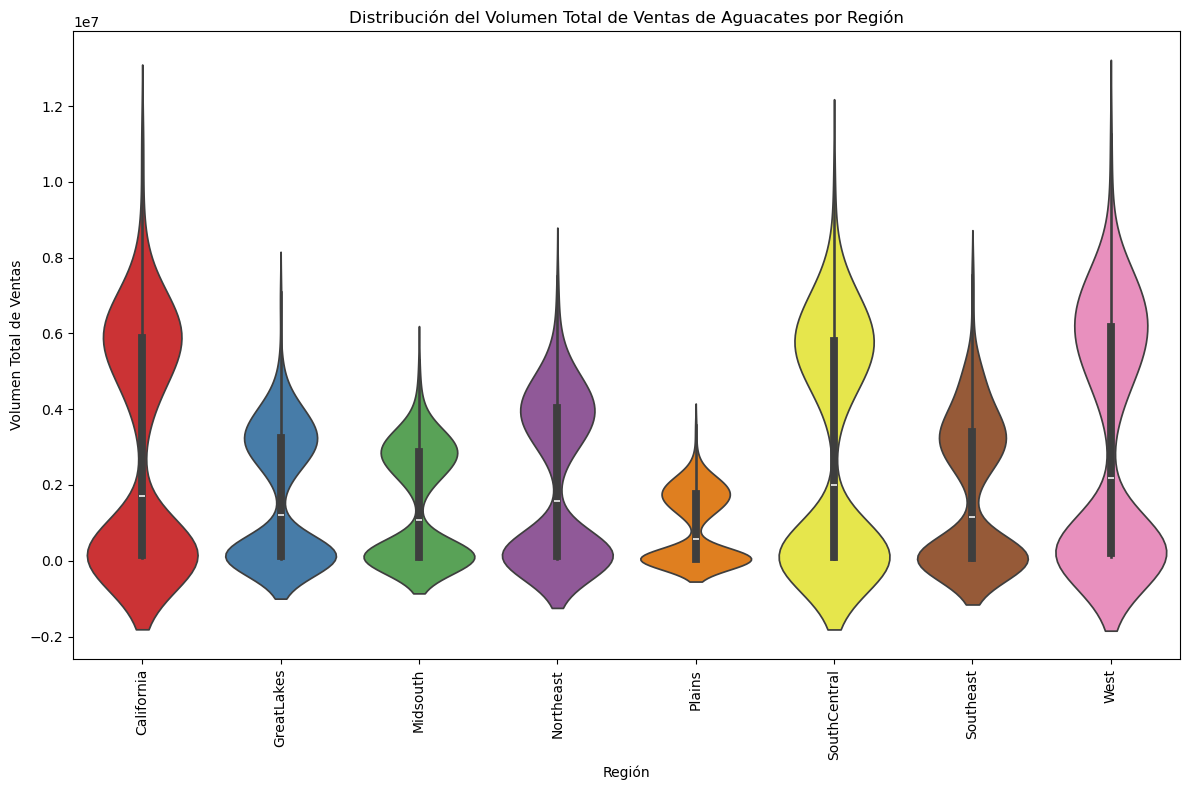

In [16]:
data_avo = df.copy()

data_avo['Date'] = pd.to_datetime(data_avo['Date'])

# Crear el gráfico de violín usando seaborn
plt.figure(figsize=(12, 8))
sns.violinplot(x='region', y='Total Volume', data=data_avo,palette='Set1')  # ,inner='quartile'

# Configurar etiquetas y títulos
plt.title('Distribución del Volumen Total de Ventas de Aguacates por Región')
plt.xlabel('Región')
plt.ylabel('Volumen Total de Ventas')

# Rotar las etiquetas del eje x para facilitar la lectura si hay muchas regiones
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Conclusiones
> La región de California presenta el mayor volumen de ventas, con una distribución más amplia y una gran variabilidad 
> en comparación con otras regiones. La parte más ancha del violín en California está cerca de la mediana, lo que sugiere que 
> la mayoría de las ventas se concentran en niveles medios de volumen

> La región de Plains tiene el rango de ventas más bajo y estrecho, con una distribución pequeña y concentrada, lo que sugiere
> ventas bajas y consistentes sin grandes fluctuaciones.

> En varias regiones, especialmente en California y West, se observan picos finos en los extremos de los violines, lo cual sugiere
> la presencia de valores atípicos o ventas excepcionales en ciertos periodos. 
> Esto puede estar relacionado con eventos puntuales de alta demanda o promociones en estas regiones.'''

# 2.2 Boxplot Comparativo de Precios entre Años:

 - Uso de Datos: Usa las columnas AveragePrice y year.
 - Esperado: Genera boxplots para comparar la distribución de precios.
 - Utiliza boxplot de seaborn para crear boxplots que comparen AveragePrice entre diferentes años.
 - Asegúrate de que cada boxplot represente un año diferente.
 - Incluye etiquetas y títulos descriptivos usando plt.title().

C:\Users\chris\AppData\Local\Temp\ipykernel_5936\3866568082.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  precio_promedio_mes = data_avo.groupby(pd.Grouper(key='Date', freq='M'))['AveragePrice'].mean().reset_index()
C:\Users\chris\AppData\Local\Temp\ipykernel_5936\3866568082.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='year', y='AveragePrice', data=precio_promedio_mes, palette='Set1',showmeans=True, meanline=True)


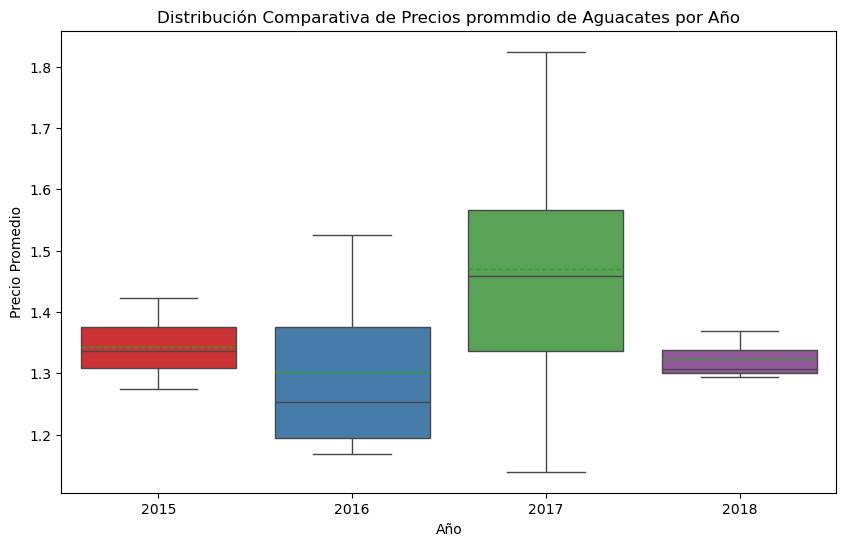

In [19]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Agrupar por mes y calcular el precio promedio
precio_promedio_mes = data_avo.groupby(pd.Grouper(key='Date', freq='M'))['AveragePrice'].mean().reset_index()

# Agregar una columna 'year' 
precio_promedio_mes['year'] = precio_promedio_mes['Date'].dt.year

# Crear el boxplot comparativo de precios entre años
sns.boxplot(x='year', y='AveragePrice', data=precio_promedio_mes, palette='Set1',showmeans=True, meanline=True)
    
# Añadir título y etiquetas de ejes
plt.title('Distribución Comparativa de Precios prommdio de Aguacates por Año')
plt.xlabel('Año')
plt.ylabel('Precio Promedio')
    
# Mostrar el gráfico
plt.show()


### 2.2 conclusion. Análisis de los precios por año
## 2015:
 > La caja es relativamente estrecha, lo que indica que los precios tuvieron una variabilidad baja o moderada en ese año.
 > La mediana (línea negra en la caja) y la media (línea punteada) están muy cerca una de otra, lo que sugiere una distribución simétrica de los precios.
 > Los bigotes también son cortos, lo que indica que no hubo valores extremos significativos y que el rango de precios fue más estable.

## 2016:
 > La caja es más amplia que en 2015, lo cual indica una mayor dispersión de precios.
 > La mediana está por debajo de la media, lo que sugiere una ligera asimetría en la distribución, con algunos precios altos que pueden estar elevando
 > el promedio.
 > Los bigotes son más largos, lo que indica que hubo más variabilidad en los precios y posiblemente algunos precios extremos, aunque no lo suficiente 
 > para clasificarse como valores atípicos.

## 2017:

 > Este año muestra la mayor variabilidad, con una caja significativamente más grande y un rango amplio de precios.
 > Los bigotes largos muestran que hubo una amplia dispersión en los precios del aguacate, y posiblemente fue un año inusual con varios valores 
 > extremos en la parte superior.


**2.3. Histograma de Volumen Total de Ventas:**
- **Uso de Datos:** Usa la columna `Total Volume`.
- **Esperado:** Crea un histograma para mostrar la distribución del volumen total de ventas.
- Utiliza `hist()` de `matplotlib` para crear el histograma.
- Ajusta el número de bins para una visualización clara usando el parámetro `bins`.
- Añade etiquetas y un título que describa lo que se muestra.'''

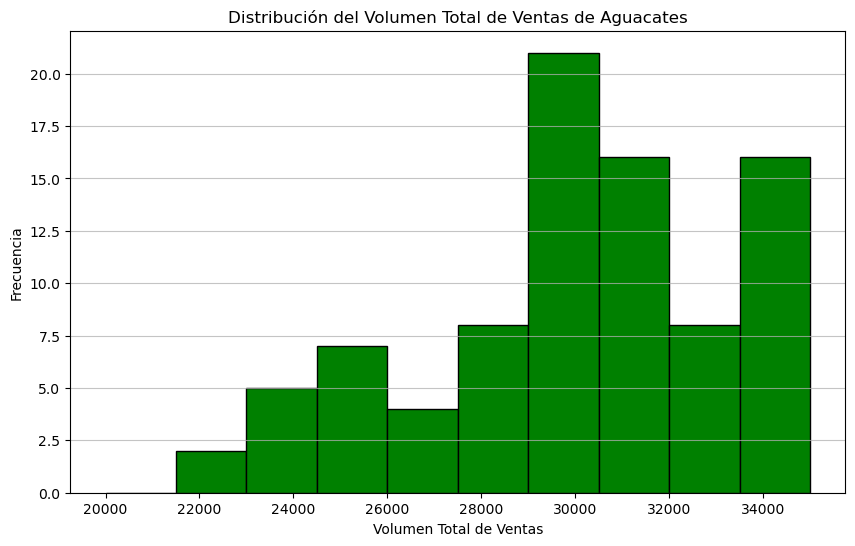

In [22]:
# 2.3 

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(data_avo['Total Volume'], bins=10, color='green', edgecolor='black',range=(20000, 35000))

# Añadir etiquetas y título
plt.title('Distribución del Volumen Total de Ventas de Aguacates')
plt.xlabel('Volumen Total de Ventas')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.grid(axis='y', alpha=0.75)
plt.show()

2.4. **Gráfico de Barras de Ventas por Tipo de Bolsa:**
   - **Uso de Datos:** Utiliza las columnas `Total Bags`, `Small Bags`, `Large Bags` y `XLarge Bags`.
   - **Esperado:** Compara las ventas de diferentes tipos de bolsas.
     - Suma los volúmenes de ventas por tipo de bolsa utilizando `sum()`.
     - Crea un gráfico de barras con `plt.bar()` para mostrar las diferencias en ventas.
     - Asegúrate de incluir etiquetas para cada tipo de bolsa.


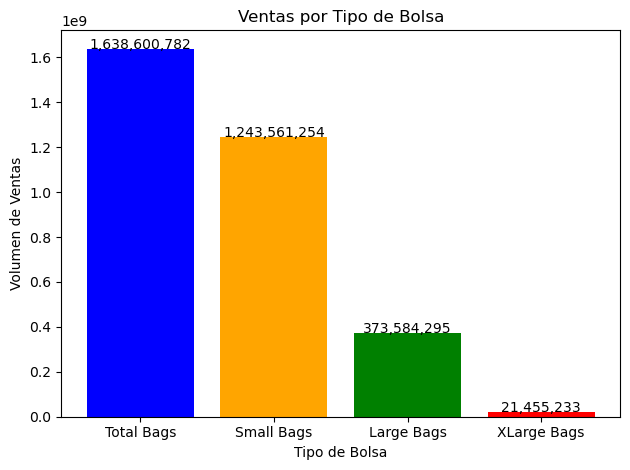

In [24]:
# Sumar volúmenes de ventas por tipo de bolsa
total_bags = data_avo['Total Bags'].sum()
small_bags = data_avo['Small Bags'].sum()
large_bags = data_avo['Large Bags'].sum()
xlarge_bags = data_avo['XLarge Bags'].sum()

# Crear una lista de tipos de bolsas y sus respectivas ventas
tipos_bolsas = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
ventas = [total_bags, small_bags, large_bags, xlarge_bags]

# Crear el gráfico de barras
plt.bar(tipos_bolsas, ventas, color=['blue', 'orange', 'green', 'red'])
plt.title('Ventas por Tipo de Bolsa')
plt.xlabel('Tipo de Bolsa')
plt.ylabel('Volumen de Ventas')

# Añadimos etiqueta para los valores exactos de cada tipo de bolsa
for i, v in enumerate(ventas):
    plt.text(i, v + 50, f'{v:,.0f}', color='black', ha='center')

# Mostrar el gráfico

plt.tight_layout()
plt.show()


2.5. **Gráfico de Líneas de Precios Promedios por Año:**
   - **Uso de Datos:** Utiliza las columnas `AveragePrice` y `year`.
   - **Esperado:** Visualiza la tendencia de precios promedio a lo largo de los años.
     - Agrupa los datos por `year` y calcula el promedio de `AveragePrice`.
     - Usa `plt.plot()` para crear un gráfico de líneas que muestre la evolución de precios.
     - Añade un título y etiquetas descriptivas a los ejes usando `plt.title()` y `plt.xlabel()`.

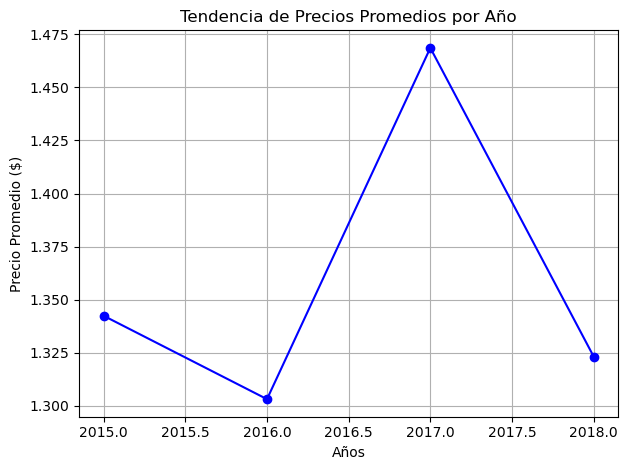

In [26]:
# Agrupar por año y calcular el precio promedio
average_prices = data_avo.groupby('year')['AveragePrice'].mean().reset_index()
# Crear el gráfico de líneas
plt.plot(average_prices['year'], average_prices['AveragePrice'], marker='o', color='b', linestyle='-')

# Añadir título y etiquetas
plt.title('Tendencia de Precios Promedios por Año')
plt.xlabel('Años')
plt.ylabel('Precio Promedio ($)')
plt.grid()  # Añadir una cuadrícula para mayor claridad

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### 3. **Elasticidad del Precio**
**Resumen:** El análisis de elasticidad precio-demanda permite evaluar cómo los cambios en los precios afectan la demanda de aguacates. Comprender la elasticidad puede ayudar a formular estrategias de precios más efectivas.

La fórmula de elasticidad precio-demanda es:

$$
E_d = \frac{\% \text{Cambio en la cantidad demandada}}{\% \text{Cambio en el precio}} = \frac{\Delta Q / Q}{\Delta P / P}
$$

3.1. **Elasticidad Precio-Demanda por Año:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Total Volume`.
   - **Esperado:** Calcula la elasticidad del precio de la demanda para cada año.
     - Calcula la variación porcentual de `Total Volume` y `AveragePrice` utilizando `pd.pct_change()`.
     - Utiliza la fórmula de elasticidad para determinar la sensibilidad de la demanda respecto al precio.
     - Presenta los resultados en un gráfico de líneas usando `plt.plot()` para mostrar la elasticidad por año.


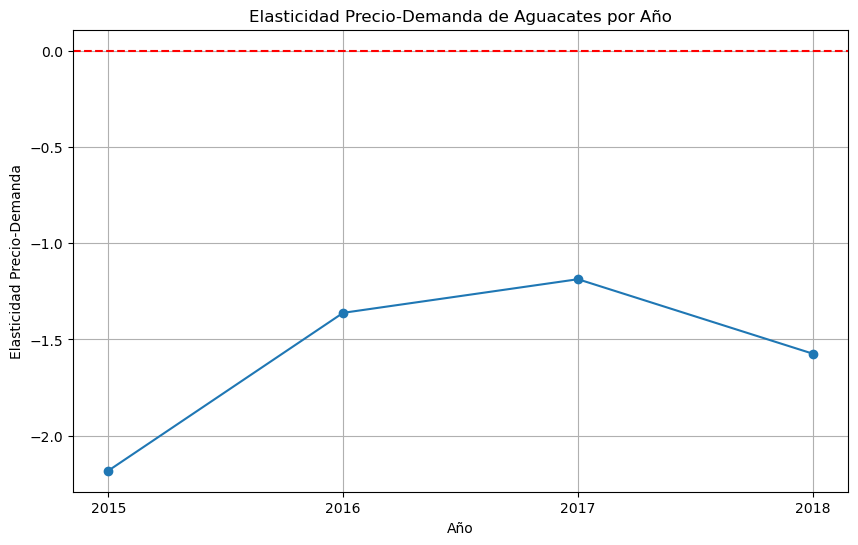

In [28]:
#3.1
data_avo = df.copy()
data_avo['Date'] = pd.to_datetime(data_avo['Date'])


# Extraer el año de la columna Date
data_avo['Year'] = data_avo['Date'].dt.year

# Calcular variación porcentual de AveragePrice y Total Volume
data_avo['Cambio Precio (%)'] = data_avo['AveragePrice'].pct_change()
data_avo['Cambio Volume (%)'] = data_avo['Total Volume'].pct_change()


# Calcular la elasticidad precio-demanda
data_avo['Elasticity'] = data_avo['Cambio Volume (%)'] / data_avo['Cambio Precio (%)']

# Eliminar NaN y valores infinitos en la columna Elasticity
data_avo = data_avo[np.isfinite(data_avo['Elasticity'])]  # Mantiene solo las filas donde Elasticity no es NaN ni infinito

# Agrupar por año y calcular la elasticidad promedio
elasticity_por_a = data_avo.groupby('Year')['Elasticity'].mean().reset_index()

# Graficar la elasticidad por año
plt.figure(figsize=(10, 6))
plt.plot(elasticity_por_a['Year'], elasticity_por_a['Elasticity'], marker='o')
plt.title('Elasticidad Precio-Demanda de Aguacates por Año')
plt.xlabel('Año')
plt.ylabel('Elasticidad Precio-Demanda')
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en y=0
plt.grid(True)
plt.xticks(elasticity_por_a['Year'])  # Asegura que todos los años se muestren en el eje x
plt.show()

# 3.1 Conclusion 

> Los valores son negativos en todo el período, lo cual es esperado, ya que en economía la elasticidad precio-demanda suele ser negativa: a medida 
> que sube el precio, la demanda tiende a disminuir.
> Los valores oscilan en un rango entre aproximadamente -2.1 y -1, indicando que la elasticidad varía en estos años.
> Interpretación de Elasticidad:

> Cuando la elasticidad es menor que -1 (como en todo el período analizado), estamos en un escenario de demanda elástica. Esto significa que los
> consumidores son sensibles a los cambios en el precio del aguacate: un aumento en el precio genera una disminución más que proporcional en la 
> cantidad demandada.
> La elasticidad más baja (en valor absoluto) se observa en 2017, alrededor de -1.2, lo cual sugiere que la demanda fue un poco menos sensible al 
> precio en comparación con otros años.  En 2017, podría haber influido también por la llamada "fiebre del aguacate" (el creciente interés por la fruta 
> en los Estados Unidos y otros países). Factores como el aumento de la demanda internacional y condiciones climáticas en los países productores
> (México, en particular) pudieron causar fluctuaciones de precio, pero con una demanda que permanecía estable debido a la alta preferencia de los 
> consumidores.

3.2. **Comparación de Elasticidad en Diferentes Mercados:**
   - **Uso de Datos:** Utiliza las columnas `Total Volume` y `AveragePrice`.
   - **Esperado:** Calcula la elasticidad del precio de la demanda en diferentes regiones.
     - Agrupa los datos por `region` y calcula la elasticidad para cada región utilizando `pd.pct_change()`.
     - Presenta un gráfico de barras que muestre la elasticidad por región usando `plt.bar()`.

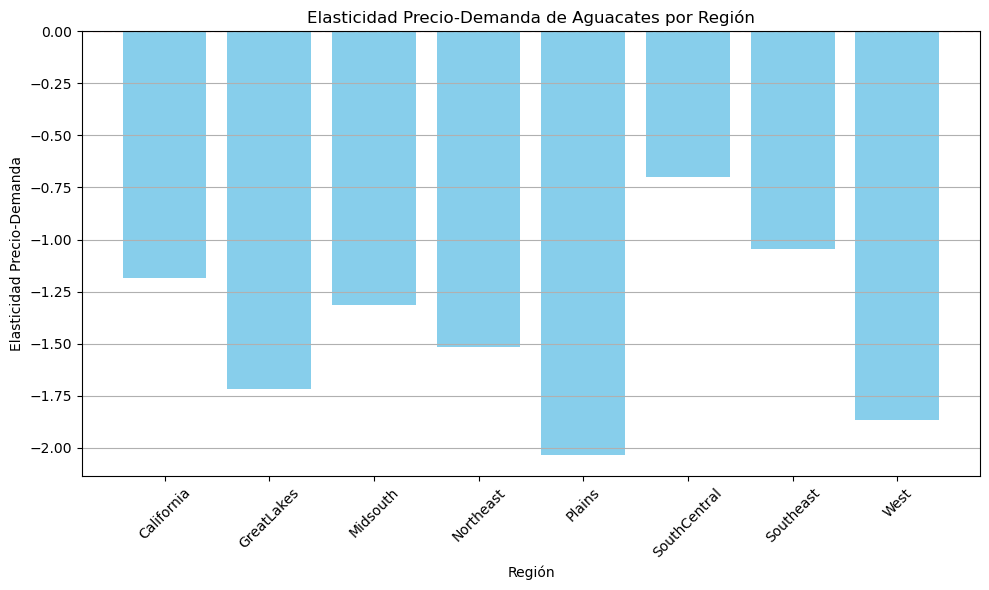

In [31]:
# Agrupar por región
data_avo = df.copy()
regions = data_avo.groupby('region')

# Crear un DataFrame para almacenar la elasticidad por región
elasticity_data = []

# Calcular elasticidad para cada región
for region, group in regions:
    # Calcular variaciones porcentuales de AveragePrice y Total Volume
    group['Price Change (%)'] = group['AveragePrice'].pct_change()
    group['Volume Change (%)'] = group['Total Volume'].pct_change()
    
    # Calcular elasticidad precio-demanda
    group['Elasticity'] = group['Volume Change (%)'] / group['Price Change (%)']
    
    # Eliminar NaN y valores infinitos en la columna Elasticity
    group = group[np.isfinite(group['Elasticity'])]  # Mantiene solo las filas válidas
    
    # Calcular la elasticidad promedio para la región
    avg_elasticity = group['Elasticity'].mean()
    elasticity_data.append({'Region': region, 'Elasticity': avg_elasticity})

# Convertir la lista a un DataFrame
elasticity_df = pd.DataFrame(elasticity_data)

# Graficar la elasticidad por región
plt.figure(figsize=(10, 6))
plt.bar(elasticity_df['Region'], elasticity_df['Elasticity'], color='skyblue')
plt.title('Elasticidad Precio-Demanda de Aguacates por Región')
plt.xlabel('Región')
plt.ylabel('Elasticidad Precio-Demanda')
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en y=0
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad
plt.grid(axis='y')
plt.tight_layout()  # Ajustar el layout para evitar superposición
plt.show()

3.2	Interpretación de los Valores Negativos:
 - 	E_d < 0: La elasticidad es negativa, lo que indica que hay una relación inversa entre precio y cantidad demandada. Esto es típico para la mayoría de los bienes y servicios.
 - 	E_d < -1: La demanda es elástica; un pequeño cambio en el precio resulta en un cambio relativamente grande en la cantidad demandada.
 - 	-1 < E_d < 0: La demanda es inelástica; un cambio en el precio resulta en un cambio menor en la cantidad demandada.
 - 	E_d = 0: La demanda es perfectamente inelástica; la cantidad demandada no cambia con los cambios en el precio.
 - 	E_d = -1: La demanda tiene elasticidad unitaria; los cambios porcentuales en precio y cantidad demandada son equivalentes.

 > La elasticidad menor que -1 indica que, entre 2015 y 2017, la demanda de aguacates en South Central fue relativamente inelástica. Esto puede atribuirse 
 > a factores socioeconómicos y culturales específicos de la región, como la importancia del aguacate en la dieta local, el poder adquisitivo relativamente alto, especialmente en áreas metropolitanas con niveles de ingresos medios y altos, como Dallas y Houston. 
 > la proximidad a México y la percepción del aguacate como un alimento saludable y esencial. La constancia en la oferta, junto con una demanda fuerte y 
 > estable debido a estos factores, ha hecho que los consumidores en South Central mantuvieran su consumo de aguacates a pesar de las variaciones de precio.


3.3 **Elasticidad a Nivel de Tipo de Bolsa:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Total Bags`.
   - **Esperado:** Calcula la elasticidad del precio de la demanda específica para cada tipo de bolsa.
     - Suma los volúmenes de ventas por tipo de bolsa utilizando `groupby()` y `sum()`.
     - Calcula la elasticidad para cada tipo y presenta los resultados en un gráfico comparativo usando `plt.bar()`.


Promedio de Elasticidad Precio-Demanda por Tipo de Bolsa:
Small Bags: -1.4862
Large Bags: -1.7440
XLarge Bags: -0.2811


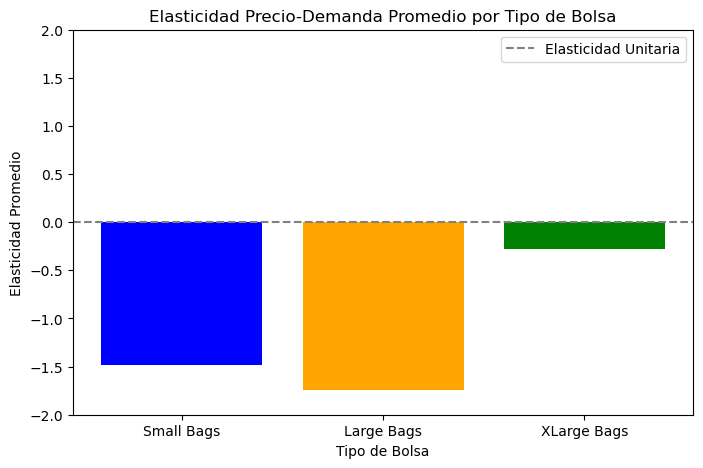

In [34]:
#3.3 Elasticidad a Nivel de Tipo de Bolsa

# Definimos las columnas que representan los diferentes tipos de bolsa
bolsas = ['Small Bags', 'Large Bags', 'XLarge Bags']
elasticidades_bolsas = {}
umbral = 0.1 

# Iteramos sobre cada tipo de bolsa
for bolsa in bolsas:
    vol_bolsas = data_avo.groupby('Date')[bolsa].sum()
    precios = data_avo.groupby('Date')['AveragePrice'].mean()
    
    # Suavización mediante un promedio móvil de 4 semanas
    vol_bolsas_suavizado = vol_bolsas.rolling(window=4).mean().dropna()
    precios_suavizado = precios.rolling(window=4).mean().dropna()
    
    # Filtrar valores bajos para evitar divisiones por números pequeños
    vol_bolsas_suavizado = vol_bolsas_suavizado[vol_bolsas_suavizado > umbral]
    precios_suavizado = precios_suavizado[precios_suavizado > umbral]
    
    # Cambios porcentuales
    pct_cambio_vol = vol_bolsas_suavizado.pct_change().dropna()
    pct_cambio_precio = precios_suavizado.pct_change().dropna()
    
    # Alineamos índices
    common_index = pct_cambio_vol.index.intersection(pct_cambio_precio.index)
    pct_cambio_vol = pct_cambio_vol[common_index]
    pct_cambio_precio = pct_cambio_precio[common_index]
    
    # Elasticidad
    elasticidad = pct_cambio_vol / pct_cambio_precio.replace(0, 1e-6)
    
    # Filtrar elasticidades extremas
    elasticidad = elasticidad[(elasticidad > -10) & (elasticidad < 10)]
    
    # Guardamos el promedio de elasticidad
    elasticidades_bolsas[bolsa] = elasticidad.mean()
    # Imprimir los resultados de elasticidad promedio

print("\nPromedio de Elasticidad Precio-Demanda por Tipo de Bolsa:")
for bolsa, elasticidad in elasticidades_bolsas.items():
    print(f"{bolsa}: {elasticidad:.4f}")

# Gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(elasticidades_bolsas.keys(), elasticidades_bolsas.values(), color=['blue', 'orange', 'green'])
plt.title("Elasticidad Precio-Demanda Promedio por Tipo de Bolsa")
plt.xlabel("Tipo de Bolsa")
plt.ylabel("Elasticidad Promedio")
plt.ylim(-2, 2)
plt.axhline(0, color='grey', linestyle='--', label="Elasticidad Unitaria")
plt.legend()
plt.show()


3.4. **Análisis de Elasticidad Comparativa entre Orgánicos y Convencionales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice`, `Total Volume` y `type`.
   - **Esperado:** Compara la elasticidad de la demanda entre aguacates orgánicos y convencionales.
     - Agrupa los datos por `type` y calcula la elasticidad utilizando `pd.pct_change()`.
     - Presenta un gráfico que muestre la diferencia en elasticidad entre los dos tipos usando `plt.bar()`.

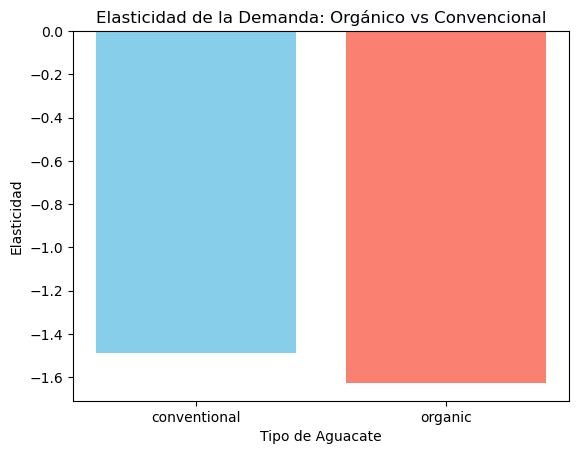

In [36]:
data_avo = df.copy()
# Crear diccionario para almacenar los resultados de elasticidad
elasticidad_tipo = {}

# Analizar elasticidad para cada tipo de aguacate (orgánico y convencional)
for tipo in data_avo['type'].unique():
    # Filtrar los datos para el tipo de aguacate
    data_tipo = data_avo[data_avo['type'] == tipo]
    
    # Agrupar por fecha y calcular el volumen total y el precio promedio
    volumen_diario = data_tipo.groupby('Date')['Total Volume'].sum()
    precio_promedio_diario = data_tipo.groupby('Date')['AveragePrice'].mean()
    
    # Calcular cambio porcentual y eliminar valores nulos
    cambio_volumen = volumen_diario.pct_change().dropna()
    cambio_precio = precio_promedio_diario.pct_change().dropna().replace(0, np.nan)
    
    # Filtrar cambios extremos para evitar valores atípicos
    cambio_volumen = cambio_volumen[(cambio_volumen > -1) & (cambio_volumen < 1)]
    cambio_precio = cambio_precio[(cambio_precio > -1) & (cambio_precio < 1)]
    
    # Chequear si hay suficientes datos para evitar errores de división o series vacías
    if cambio_volumen.empty or cambio_precio.empty:
        print(f"No hay datos suficientes para calcular elasticidad para el tipo: {tipo}")
        continue  # Saltar si faltan datos
    
    # Calcular elasticidad como la mediana de los cambios en volumen dividido por los cambios en precio
    elasticidad = (cambio_volumen / cambio_precio).median()
    elasticidad_tipo[tipo] = elasticidad  # Guardar el resultado

# Verificar si el diccionario tiene datos antes de graficar
if elasticidad_tipo:
    # Graficar la elasticidad
    plt.bar(elasticidad_tipo.keys(), elasticidad_tipo.values(), color=['skyblue', 'salmon'])
    plt.title("Elasticidad de la Demanda: Orgánico vs Convencional")
    plt.xlabel("Tipo de Aguacate")
    plt.ylabel("Elasticidad")
    plt.show()
else:
    print("No se encontraron datos suficientes para graficar elasticidades.")

3.5. **Análisis de la Elasticidad Precios-Ventas:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Total Volume`.
   - **Esperado:** Examina cómo las variaciones en `AveragePrice` afectan a `Total Volume`.
     - Realiza un análisis de la relación entre estas dos variables calculando la elasticidad.
     - Presenta un gráfico de dispersión que muestre la relación y discute la tendencia observada utilizando `plt.scatter()` y `plt.plot()`.

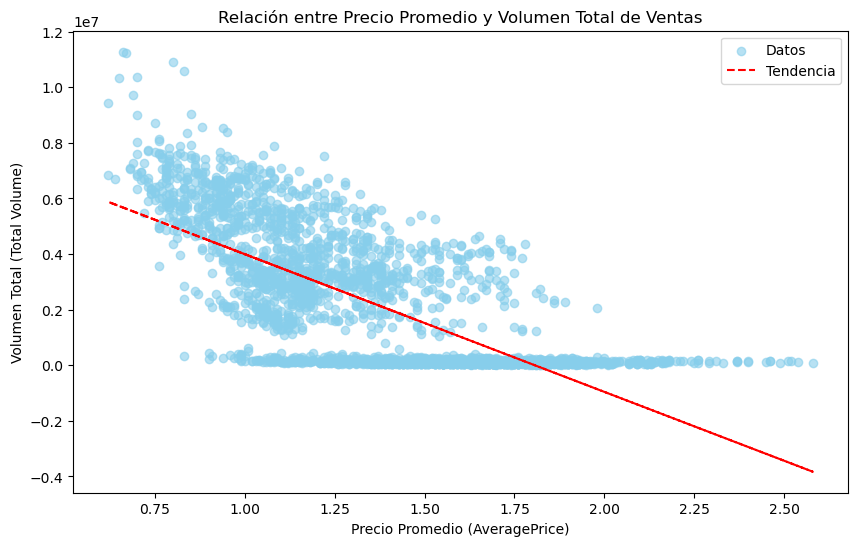

Elasticidad Precio-Ventas Promedio: nan


E:\conda\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [38]:
data_avo = df.copy()
# Calcular el cambio porcentual en precio promedio y volumen total
cambio_precio = data_avo['AveragePrice'].pct_change()
cambio_volumen = data_avo['Total Volume'].pct_change()

# Calcular elasticidad como el cambio en volumen dividido por el cambio en precio
elasticidad = cambio_volumen / cambio_precio

# Gráfico de dispersión entre precio promedio y volumen total
plt.figure(figsize=(10, 6))
plt.scatter(data_avo['AveragePrice'], data_avo['Total Volume'], color='skyblue', alpha=0.6, label="Datos")
plt.title("Relación entre Precio Promedio y Volumen Total de Ventas")
plt.xlabel("Precio Promedio (AveragePrice)")
plt.ylabel("Volumen Total (Total Volume)")

# Agregar una línea de tendencia
z = np.polyfit(data_avo['AveragePrice'].dropna(), data_avo['Total Volume'].dropna(), 1) 
p = np.poly1d(z)
plt.plot(data_avo['AveragePrice'], p(data_avo['AveragePrice']), "r--", label="Tendencia")

plt.legend()
plt.show()

# Calcular y mostrar elasticidad promedio
elasticidad_promedio = elasticidad.mean()
print(f"Elasticidad Precio-Ventas Promedio: {elasticidad_promedio:.2f}")

### 4. **Análisis de Cohortes**
**Resumen:** El análisis de cohortes permite agrupar datos según características específicas y observar cómo se comportan a lo largo del tiempo. Se centra en cohortes de precios y ventas para entender las dinámicas del mercado.

4.1. **Cohortes Basadas en Precios Promedios Trimestrales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice`, `Total Volume` y `Date`.
   - **Esperado:** Crea cohortes trimestrales y analiza cambios en precios y volúmenes.
     - Agrupa los datos por trimestre usando `pd.Grouper` con `freq='Q'`.
     - Calcula el promedio de `AveragePrice` y suma `Total Volume` para cada cohorte.
     - Visualiza los resultados en un gráfico de líneas que muestre la evolución de las cohortes.

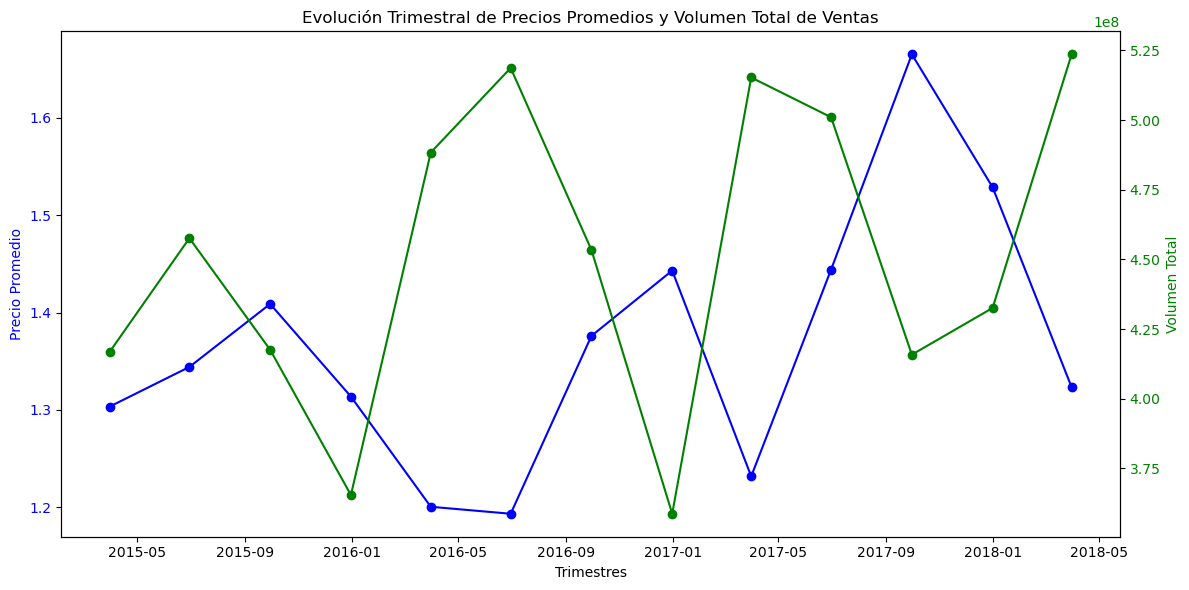

In [40]:
data_avo['Date'] = pd.to_datetime(data_avo['Date'])
data_avo['Date'] = pd.to_datetime(data_avo['Date'], errors='coerce')

# Agrupar por trimestre y calcular el promedio de precios y la suma de volúmenes
cohortes_trimestrales = data_avo.groupby(pd.Grouper(key='Date', freq='QE')).agg({
    'AveragePrice': 'mean',
    'Total Volume': 'sum'
}).reset_index()


# Crear el gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de la evolución de precios promedio en el eje y izquierdo
ax1.plot(cohortes_trimestrales['Date'], cohortes_trimestrales['AveragePrice'], color='blue', marker='o', label='Precio Promedio')
ax1.set_xlabel('Trimestres')
ax1.set_ylabel('Precio Promedio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Evolución Trimestral de Precios Promedios y Volumen Total de Ventas')

# Crear el segundo eje y para el volumen total de ventas derecho 
ax2 = ax1.twinx()  # Crear un segundo eje y que comparte el eje x con el primero
ax2.plot(cohortes_trimestrales['Date'], cohortes_trimestrales['Total Volume'], color='green', marker='o', label='Volumen Total')
ax2.set_ylabel('Volumen Total', color='green')
ax2.tick_params(axis='y', labelcolor='green')


# Añadir leyendas y ajuste del layout
fig.tight_layout()  # Ajusta el layout para evitar superposición
plt.show()

### 4.2. **Cohortes por Región y Fecha:**
   - **Uso de Datos:** Utiliza las columnas `AveragePrice`, `Total Volume`, `region` y `Date`.
   - **Esperado:** Analiza cómo varían las cohortes de diferentes regiones.
     - Agrupa los datos por `region` y `Date` usando `groupby()`.
     - Calcula el promedio de precios y volumen para cada cohorte.
     - Presenta los resultados en gráficos de barras que muestren comparaciones entre regiones.

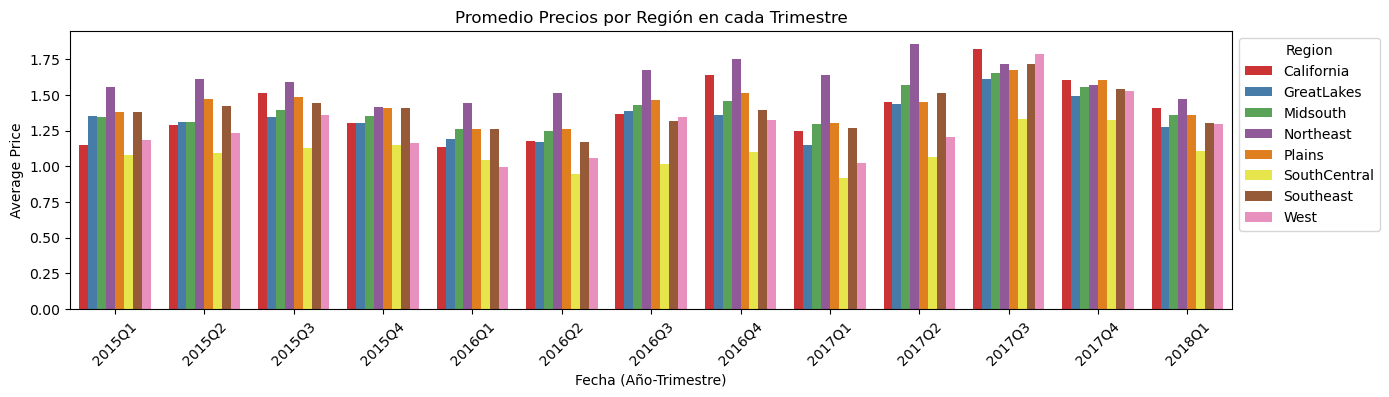

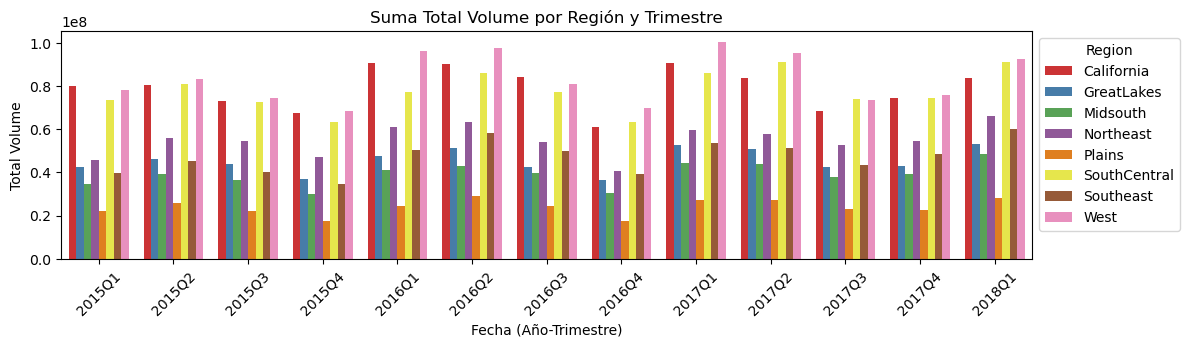

In [42]:
cohort_region = data_avo.groupby(['region', pd.Grouper(key='Date', freq='QE')]).agg({
    'AveragePrice': 'mean',
    'Total Volume': 'sum'
}).reset_index()

# Crear una columna para año y trimestre en formato 'YYYY-Tn' (T1, T2, T3, T4)
cohort_region['trimestre'] = cohort_region['Date'].dt.to_period('Q').astype(str)

# para la visualización
plt.figure(figsize=(14, 7))

# Gráfico de barras Average Price por región
plt.subplot(2, 1, 1)
sns.barplot(data=cohort_region, x='trimestre', y='AveragePrice', hue='region', palette='Set1')
plt.title('Promedio Precios por Región en cada Trimestre')
plt.xlabel('Fecha (Año-Trimestre)')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.legend(title='Region', loc='best', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.tight_layout()


plt.figure(figsize=(12, 6))

# Gráfico de barras para Average Price para Total Volume
plt.subplot(2, 1, 1)
sns.barplot(data=cohort_region, x='trimestre', y='Total Volume', hue='region', palette='Set1')
plt.title('Suma Total Volume por Región y Trimestre')
plt.xlabel('Fecha (Año-Trimestre)')
plt.ylabel('Total Volume')
plt.xticks(rotation=45)
plt.legend(title='Region', loc='best', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.tight_layout()

4.3. **Análisis de Cohortes en Función del Tipo de Bolsa:**
   - **Uso de Datos:** Usa las columnas `Total Bags`, `Small Bags`, `Large Bags`, `XLarge Bags` y `Date`.
   - **Esperado:** Examina cómo se comportan las diferentes cohortes según el tipo de bolsa.
     - Agrupa los datos por tipo de bolsa y `Date`.
     - Calcula el volumen de ventas total y muestra los resultados en un gráfico de líneas.

<class 'pandas.core.frame.DataFrame'>
Index: 2704 entries, 312 to 18236
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    2704 non-null   int64         
 1   Date          2704 non-null   datetime64[ns]
 2   AveragePrice  2704 non-null   float64       
 3   Total Volume  2704 non-null   float64       
 4   4046          2704 non-null   float64       
 5   4225          2704 non-null   float64       
 6   4770          2704 non-null   float64       
 7   Total Bags    2704 non-null   float64       
 8   Small Bags    2704 non-null   float64       
 9   Large Bags    2704 non-null   float64       
 10  XLarge Bags   2704 non-null   float64       
 11  type          2704 non-null   object        
 12  year          2704 non-null   int64         
 13  region        2704 non-null   object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 381.4+ KB
None


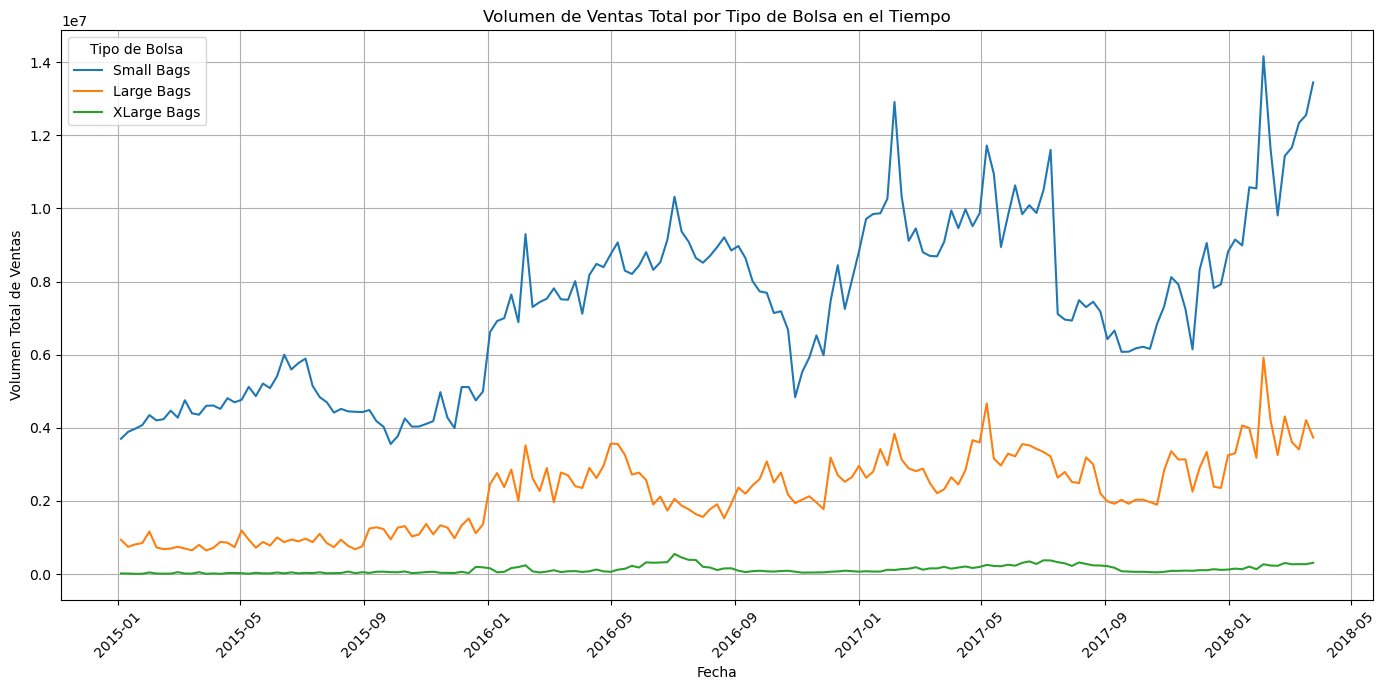

In [44]:
print(data_avo.info())
#4.3 Análisis de Cohortes en Función del Tipo de Bolsa:

#Crear un DataFrame para las ventas totales por tipo de bolsa
bag_sales = data_avo[['Date', 'Small Bags', 'Large Bags', 'XLarge Bags']].groupby('Date').sum()

#Graficar el volumen total de ventas para cada tipo de bolsa
plt.figure(figsize=(14, 7))
for bag_type in ['Small Bags', 'Large Bags', 'XLarge Bags']:
    plt.plot(bag_sales.index, bag_sales[bag_type], label=bag_type)

#Configuración del gráfico
plt.title("Volumen de Ventas Total por Tipo de Bolsa en el Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Volumen Total de Ventas")
plt.legend(title="Tipo de Bolsa")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

#Mostrar el gráfico
plt.show()

### 4.4 Cohortes de Clientes Basadas en Ventas:
- Uso de Datos: Usa las columnas Total Volume, Date y region.
-  Esperado: Analiza el comportamiento de las cohortes según el volumen de ventas.
-  Clasifica los clientes según su volumen de compras.
-  Visualiza las cohortes en gráficos de líneas o barras que muestren el comportamiento de compra a lo largo del tiempo

C:\Users\chris\AppData\Local\Temp\ipykernel_5936\2019854646.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_avo_filt['Date'] = pd.to_datetime(data_avo_filt['Date'], errors='coerce')
C:\Users\chris\AppData\Local\Temp\ipykernel_5936\2019854646.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_avo_filt['Month'] = data_avo_filt['Date'].dt.to_period('M')  # Extraer mes y año
C:\Users\chris\AppData\Local\Temp\ipykernel_5936\2019854646.py:23: FutureWarning: The default of observed=False is depreca

<Figure size 1800x900 with 0 Axes>

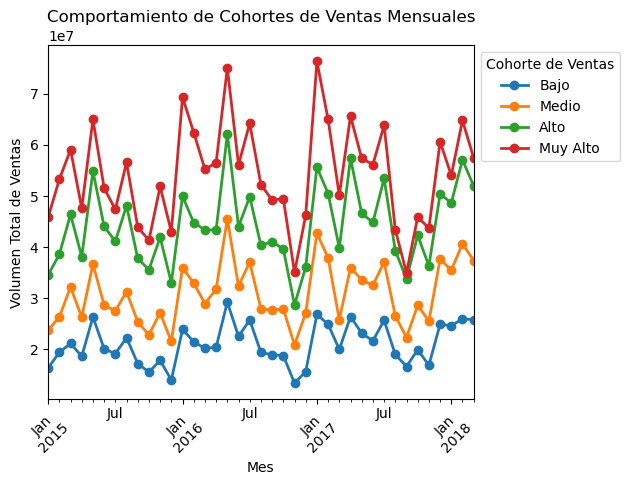

In [46]:
# Filtrar solo las columnas necesarias
data_avo_filt = data_avo[['Date', 'region', 'Total Volume']]

# Convertir la columna 'Date' a tipo datetime si no lo está
data_avo_filt['Date'] = pd.to_datetime(data_avo_filt['Date'], errors='coerce')

# Clasificar las regiones en base al volumen de ventas total
# Agrupamos por región y calculamos el total de ventas
region_volume = data_avo_filt.groupby('region')['Total Volume'].sum().reset_index()

# Crear cohortes mensuales y calcular el volumen total de ventas para cada cohorte y mes
data_avo_filt['Month'] = data_avo_filt['Date'].dt.to_period('M')  # Extraer mes y año

# Clasificación de regiones en base a percentiles
# Definimos categorías en percentiles para crear cohortes
region_volume['Total Volume'] = region_volume['Total Volume'].fillna(0)  # Asegurarnos de que no haya NaN
region_volume['Cohorte'] = pd.qcut(region_volume['Total Volume'], q=4, labels=['Bajo', 'Medio', 'Alto', 'Muy Alto'])

# Unir la clasificación con el conjunto de datos original
data_avo_filt = data_avo_filt.merge(region_volume[['region', 'Cohorte']], on='region', how='left')

# Agrupar por mes y cohorte, sumando el volumen total de ventas
monthly_cohorts = data_avo_filt.groupby(['Month', 'Cohorte'])['Total Volume'].sum().unstack().fillna(0)

# Visualización del comportamiento de compra a lo largo del tiempo
plt.figure(figsize=(18, 9))
monthly_cohorts.plot(kind='line', marker='o', linewidth=2)
plt.title('Comportamiento de Cohortes de Ventas Mensuales')
plt.xlabel('Mes')
plt.ylabel('Volumen Total de Ventas')
# Colocar la leyenda fuera del gráfico
plt.legend(title='Cohorte de Ventas', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



 4.5. **Evaluación de Retención de Ventas por Cohorte:**
   - **Uso de Datos:** Usa las columnas `Total Volume` y `Date`.
   - **Esperado:** Estudia cómo se retienen las ventas en cohortes a lo largo de un año.
     - Agrupa los datos por mes y cohortes.
     - Calcula la retención de ventas y visualiza los resultados en un gráfico de líneas que muestre las tasas de retención.

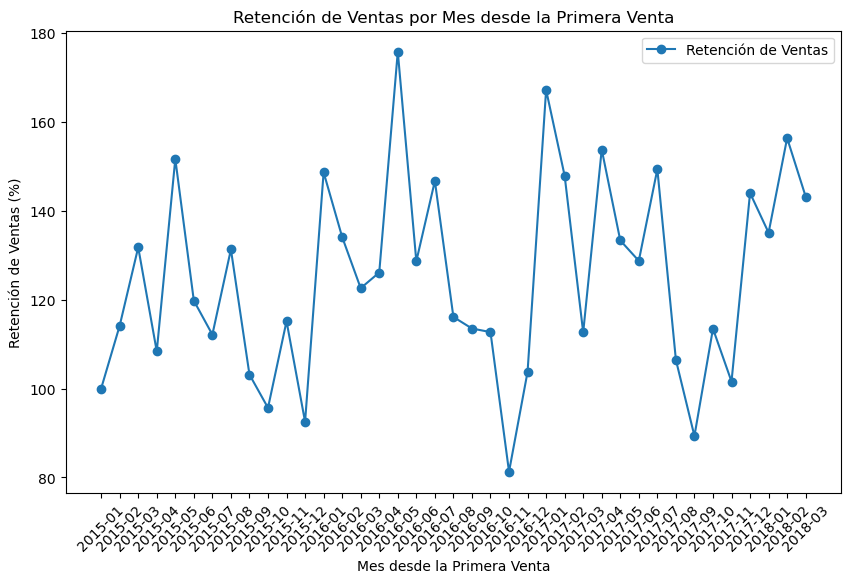

In [48]:
# crear una columna de mes 
data_avo['Date'] = pd.to_datetime(data_avo['Date'])
data_avo['Mes'] = data_avo['Date'].dt.to_period('M')  # convierte la fecha al formato de periodo mensual


## Agrupar por Mes para obtener el volumen de ventas mensual total
ventas_mensuales = data_avo.groupby('Mes')['Total Volume'].sum()

# Crear la columna Cohorte, que será el mes de la primera venta
ventas_mensuales = ventas_mensuales.reset_index()
ventas_mensuales['Cohorte'] = ventas_mensuales['Mes'].iloc[0]  # Primer mes con datos de ventas

# Calcular la retención de ventas relativa al volumen inicial
ventas_mensuales['Retencion'] = (ventas_mensuales['Total Volume'] / ventas_mensuales['Total Volume'].iloc[0]) * 100

# Visualización de la tasa de retención
plt.figure(figsize=(10, 6))
plt.plot(ventas_mensuales['Mes'].astype(str), ventas_mensuales['Retencion'], marker='o', label='Retención de Ventas')

plt.title('Retención de Ventas por Mes desde la Primera Venta')
plt.xlabel('Mes desde la Primera Venta')
plt.ylabel('Retención de Ventas (%)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### 5. **Análisis de Correlación y Regresión**
**Resumen:** Se centra en la identificación de relaciones significativas entre las variables numéricas y el desarrollo de modelos de regresión para hacer predicciones basadas en esas relaciones.

1. **Matriz de Correlación:** 
   - **Uso de Datos:** Utiliza las columnas numéricas del DataFrame (p. ej., `AveragePrice`, `Total Volume`, `4046`, `4225`, `4770`, `Total Bags`).
   - **Esperado:** 
     - Importa las librerías necesarias: `import seaborn as sns` y `import matplotlib.pyplot as plt`.
     - Calcula la matriz de correlación usando el método `.corr()` del DataFrame.
     - Visualiza la matriz utilizando `sns.heatmap()`. 
     - Anota las correlaciones más significativas y discute su posible impacto en el análisis.

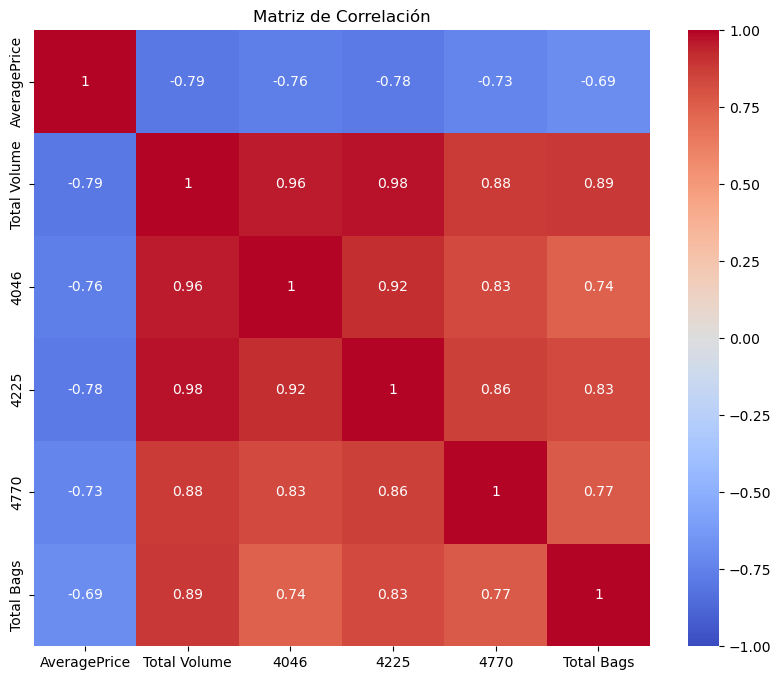

In [50]:
data_avo = df.copy()
regiones=["California"]
data_avo=data_avo[data_avo['region'].isin(regiones)]
corr_matrix = data_avo[['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Matriz de Correlación")
plt.show()

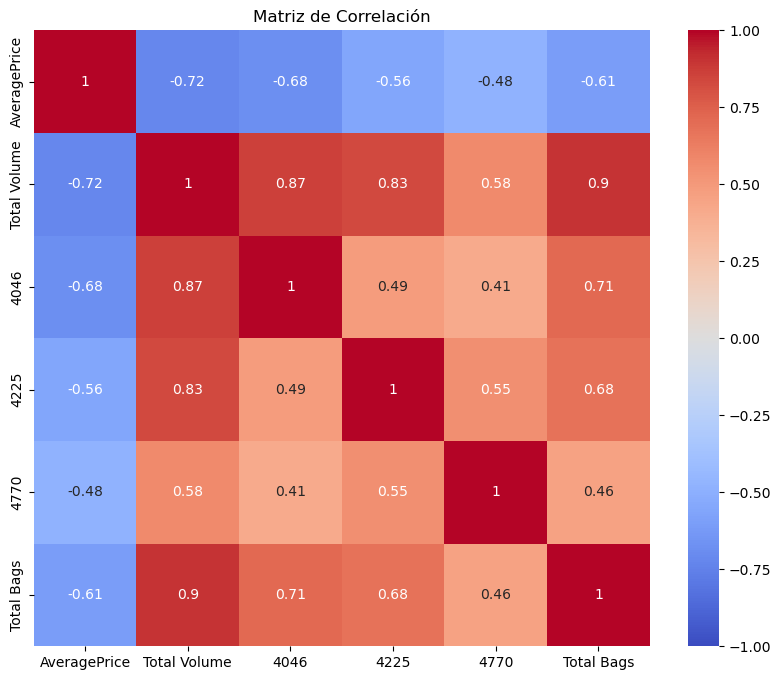

In [51]:
data_avo = df.copy()
corr_matrix = data_avo[['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Matriz de Correlación")
plt.show()


In [52]:
'''
Viendo el mapa de calor, vemos las siguientes correlaciones altas:
-Total Volume y Total Bags con 0.9
-Total Volume con 4046 0.87
-Total Volume con 4225 0.83

Esto sugiere que puede haber una fuerte relación lineal entre esos campos.
'''

'\nViendo el mapa de calor, vemos las siguientes correlaciones altas:\n-Total Volume y Total Bags con 0.9\n-Total Volume con 4046 0.87\n-Total Volume con 4225 0.83\n\nEsto sugiere que puede haber una fuerte relación lineal entre esos campos.\n'

2. **Análisis de Dispersión entre Variables Clave:** 
   - **Uso de Datos:** Selecciona variables numéricas de interés como `AveragePrice` y `Total Volume`.
   - **Esperado:** 
     - Importa las librerías necesarias: `import seaborn as sns` y `import matplotlib.pyplot as plt`.
     - Crea un gráfico de dispersión con `sns.scatterplot()` para visualizar la relación entre `AveragePrice` y `Total Volume`.
     - Añade una línea de regresión utilizando `sns.regplot()` para ilustrar las tendencias.
     - Compara el ajuste de una regresión lineal frente a una polinómica.

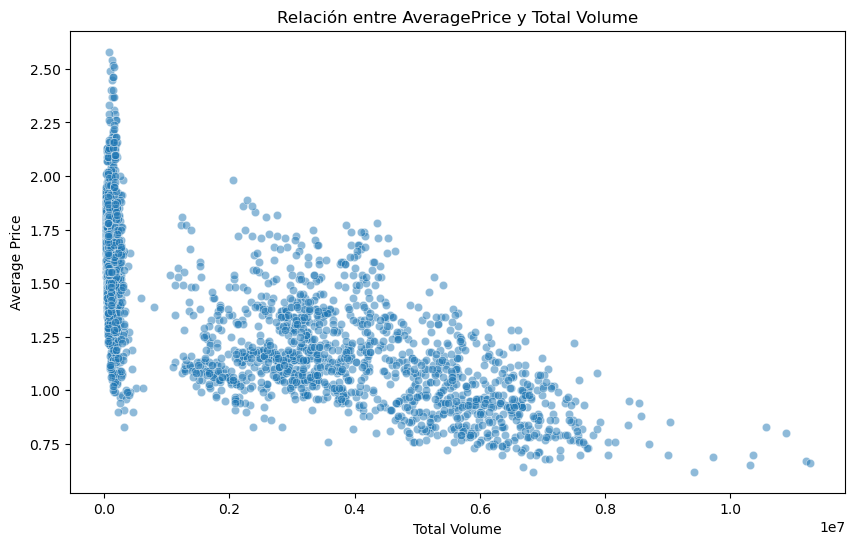

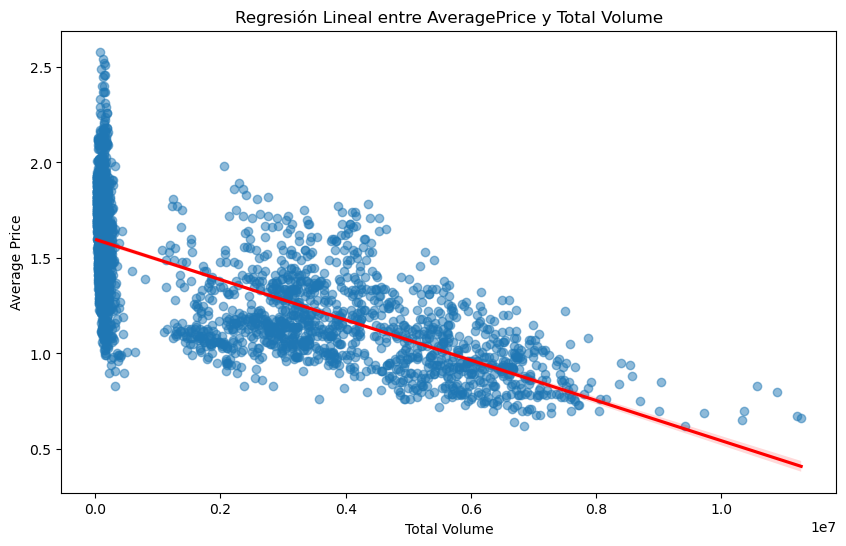

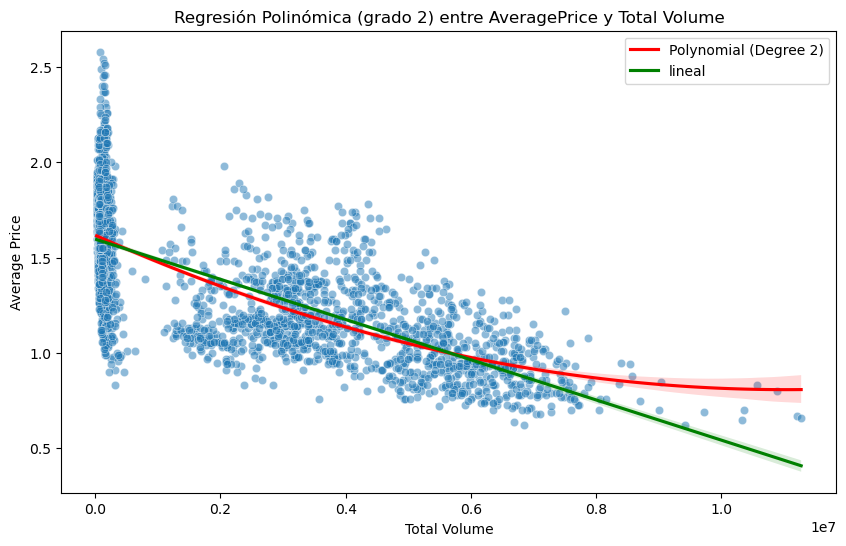

In [54]:
# 1. Gráfico de dispersión entre AveragePrice y Total Volume
#df=data_avo
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_avo, x='Total Volume', y='AveragePrice', alpha=0.5)
plt.title('Relación entre AveragePrice y Total Volume')
plt.xlabel('Total Volume')
plt.ylabel('Average Price')
plt.show()

#Añadimos una línea de regresión lineal
plt.figure(figsize=(10, 6))
sns.regplot(data=data_avo, x='Total Volume', y='AveragePrice', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Regresión Lineal entre AveragePrice y Total Volume')
plt.xlabel('Total Volume')
plt.ylabel('Average Price')
plt.show()

# 3. Ajusta y grafica una regresión polinómica (por ejemplo, grado 2)
# Crea un modelo de regresión polinómica
degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
X = data_avo[['Total Volume']].values
y = data_avo['AveragePrice'].values
poly_model.fit(X, y)
y_pred_poly = poly_model.predict(X)

# Grafica el ajuste de la regresión polinómica junto con el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_avo, x='Total Volume', y='AveragePrice', alpha=0.5)
#plt.plot(data_avo['Total Volume'], y_pred_poly, color='green', label=f'Regresión Polinómica (grado {degree})')
sns.regplot(x='Total Volume', y='AveragePrice', data=data_avo, scatter=False, order=2, label='Polynomial (Degree 2)', color='red')
sns.regplot(x='Total Volume', y='AveragePrice', data=data_avo, scatter=False, label='lineal', color='green')
plt.title(f'Regresión Polinómica (grado {degree}) entre AveragePrice y Total Volume')
plt.xlabel('Total Volume')
plt.ylabel('Average Price')
plt.legend()
plt.show()

3. **Predicciones Mensuales Usando Datos Trimestrales:**
   - **Uso de Datos:** Agrupa datos por trimestres y segmenta en meses utilizando `Date`, `AveragePrice`, y `Total Volume`.
   - **Esperado:** 
     - Convierte la columna `Date` a tipo datetime si es necesario.
     - Agrupa los datos por trimestre y calcula el promedio de `AveragePrice` y `Total Volume`.
     - Utiliza los datos de los primeros 2 meses de un trimestre para predecir el precio del tercer mes.
     - Compara los resultados de las predicciones con los precios reales.
     - Evalúa la precisión de tus predicciones utilizando métricas como R² y RMSE.

Modelo - R^2: 0.9493909141311523, RMSE: 0.04773475371555184


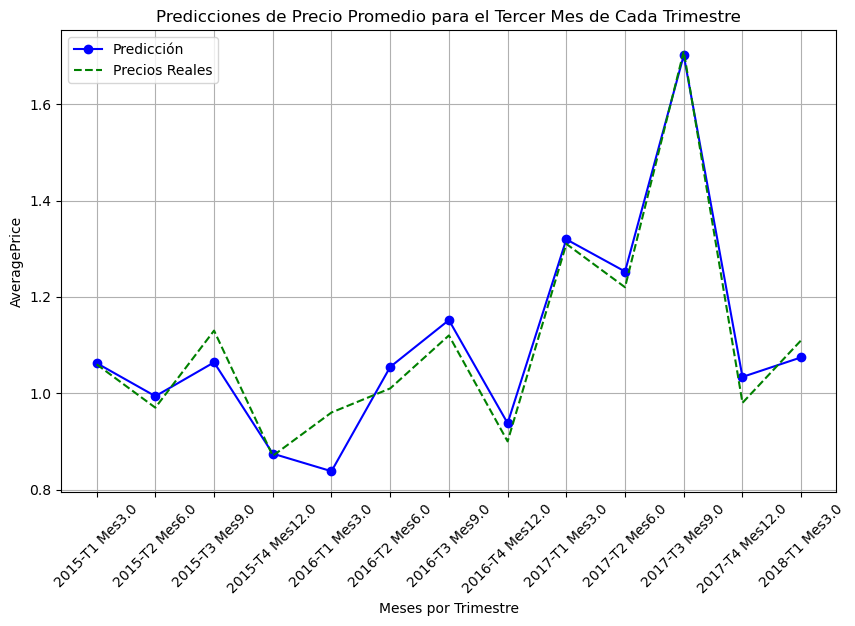

In [183]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

data_avo['Date'] = pd.to_datetime(data_avo['Date'])

# Crear la columna 'Año' y 'Mes'
data_avo['Año'] = data_avo['Date'].dt.year
data_avo['Mes'] = data_avo['Date'].dt.month

# Crear la columna 'Trimestre' para identificar a qué trimestre corresponde cada mes
data_avo['Trimestre'] = ((data_avo['Mes'] - 1) // 3) + 1  # Calcular el trimestre

# Filtrar solo las columnas numéricas de interés para el análisis
df_trimestral = data_avo[['Año', 'Mes', 'Trimestre', 'AveragePrice', 'Total Volume']]

# Inicializamos las listas para almacenar los resultados
meses = []
predicciones = []
precios_actuales = []

# Iterar por cada trimestre para usar los dos primeros meses para predecir el tercero
for año in data_avo['Año'].unique():
    for trimestre in range(1, 5):  # Iterar por cada trimestre (1, 2, 3, 4)
        # Filtramos los datos para el año y trimestre específicos
        df_trimestre = df_trimestral[(df_trimestral['Año'] == año) & (df_trimestral['Trimestre'] == trimestre)]
        
        if len(df_trimestre) >= 3:  # Asegurarse de que hay al menos 3 meses para el trimestre
            # Usamos los dos primeros meses para predecir el tercero
            meses_train = df_trimestre.iloc[:2]  # Dos primeros meses
            mes_prediccion = df_trimestre.iloc[2]  # Tercer mes (a predecir)
            
            # Variables para el entrenamiento (primeros 2 meses)
            X_train = meses_train[['Mes', 'AveragePrice', 'Total Volume']].values  # Convertimos a array
            y_train = meses_train['AveragePrice']  # Precio del primer y segundo mes
            
            # Variable para la predicción (tercer mes)
            X_test = mes_prediccion[['Mes', 'AveragePrice', 'Total Volume']].values.reshape(1, -1)  # Convertimos a array
            y_test = mes_prediccion['AveragePrice']
            
            # Ajuste del modelo de regresión lineal
            model = LinearRegression()
            model.fit(X_train, y_train)
            
            # Predicción del precio para el tercer mes
            prediccion = model.predict(X_test)[0]
            
            # Almacenar los resultados
            predicciones.append(prediccion)
            precios_actuales.append(y_test)
            meses.append(f'{año}-T{trimestre} Mes{mes_prediccion["Mes"]}')

# Convertir las listas de predicciones y precios reales a arrays
predicciones = np.array(predicciones)
precios_actuales = np.array(precios_actuales)

# Evaluar el rendimiento del modelo con R^2 y RMSE
r2 = r2_score(precios_actuales, predicciones)
rmse = np.sqrt(mean_squared_error(precios_actuales, predicciones))

# Mostrar las métricas de rendimiento
print(f"Modelo - R^2: {r2}, RMSE: {rmse}")

# Graficar los resultados
plt.figure(figsize=(10, 6))

# Gráfico de las predicciones frente a los precios reales
plt.plot(meses, predicciones, label='Predicción', color='blue', marker='o')
plt.plot(meses, precios_actuales, label='Precios Reales', color='green', linestyle='--')

plt.xlabel('Meses por Trimestre')
plt.ylabel('AveragePrice')
plt.title('Predicciones de Precio Promedio para el Tercer Mes de Cada Trimestre')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


4. **Predicciones Trimestrales:**
   - **Uso de Datos:** Agrupa los datos en trimestres usando solo variables numéricas.
   - **Esperado:** 
     - Agrupa los datos por trimestres usando `pd.Grouper()` con `freq='Q'` para obtener promedios.
     - Usa los datos de 1 o 2 trimestres anteriores para predecir el siguiente trimestre ajustando modelos de regresión lineal y polinómica.
     - Compara los resultados de las predicciones con los precios reales.
     - Evalúa la precisión de tus predicciones utilizando métricas como R² y RMSE.

C:\Users\chris\AppData\Local\Temp\ipykernel_5936\2143445524.py:15: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_trimestral = data_avo.groupby(pd.Grouper(key='Date', freq='Q')).agg({'AveragePrice': 'mean', 'Total Volume': 'mean'}).reset_index()


Modelo de Regresión Lineal - R^2: 1.0, RMSE: 2.1259152388627147e-16
Modelo de Regresión Polinómica - R^2: 1.0, RMSE: 1.1102230246251565e-16
Modelo Ridge - R^2: 1.0, RMSE: 1.5594505607334805e-11


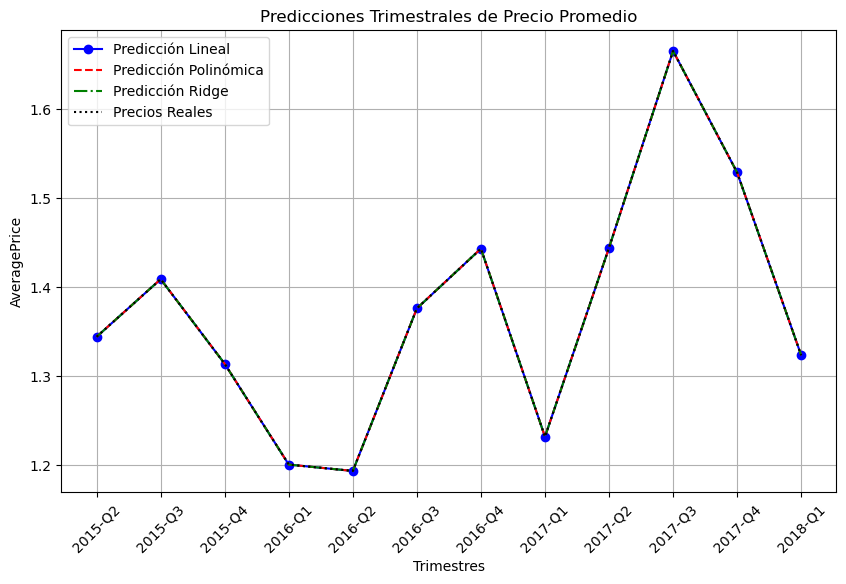

'\nposibles causas\nPequeño tamaño de datos: puede que no haya suficientes puntos de entrenamiento para que los modelos generalicen correctamente.\nCaracterísticas demasiado predictivas: Si los datos son muy lineales o tienen una relación muy clara entre las características (como en el caso de datos económicos trimestrales), los modelos lineales (y especialmente Ridge) pueden ajustarse de manera casi perfecta.\nRegularización en Ridge: Aunque el modelo Ridge utiliza regularización, en casos de sobreajuste, esto puede no ser suficiente, dependiendo de los datos.\n'

In [211]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

data_avo = df.copy()

data_avo['Date'] = pd.to_datetime(data_avo['Date'])

# Agrupar por trimestres utilizando pd.Grouper() y calcular el promedio para cada trimestre
df_trimestral = data_avo.groupby(pd.Grouper(key='Date', freq='Q')).agg({'AveragePrice': 'mean', 'Total Volume': 'mean'}).reset_index()
# Listas para almacenar los resultados
trimestres = []
predicciones_lineales = []
predicciones_polinomicas = []
predicciones_ridge = []  # Lista para Ridge
precios_reales = []

# Iterar para predecir el siguiente trimestre usando los dos trimestres anteriores
for i in range(len(df_trimestral) - 1):  # Iteramos hasta el penúltimo trimestre
    trimestre_actual = df_trimestral.iloc[i]
    trimestre_siguiente = df_trimestral.iloc[i + 1]
    
    # Usar los datos de los dos trimestres anteriores para entrenar
    X_train = df_trimestral.iloc[i:i+2][['AveragePrice', 'Total Volume']].values  # Tomar los dos trimestres anteriores
    y_train = df_trimestral.iloc[i:i+2]['AveragePrice'].values  # Variable objetivo: AveragePrice
    
    # Datos para predecir el siguiente trimestre
    X_test = trimestre_siguiente[['AveragePrice', 'Total Volume']].values.reshape(1, -1)
    y_test = trimestre_siguiente['AveragePrice']
    
    # Modelo de regresión lineal
    model_linear = LinearRegression()
    model_linear.fit(X_train, y_train)
    prediccion_lineal = model_linear.predict(X_test)[0]
    
    # Modelo de regresión polinómica (grado 2)
    poly = PolynomialFeatures(degree=3)
    X_train_poly = poly.fit_transform(X_train)
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)
    X_test_poly = poly.transform(X_test)
    prediccion_polinomica = model_poly.predict(X_test_poly)[0]

    # Modelo Ridge (regresión lineal con regularización)
    model_ridge = Ridge(alpha=1.0)
    model_ridge.fit(X_train, y_train)
    prediccion_ridge = model_ridge.predict(X_test)[0]
    
    # Almacenar los resultados
    predicciones_lineales.append(prediccion_lineal)
    predicciones_polinomicas.append(prediccion_polinomica)
    predicciones_ridge.append(prediccion_ridge)  # Guardar la predicción de Ridge
    precios_reales.append(y_test)
    trimestres.append(f'{trimestre_siguiente["Date"].year}-Q{trimestre_siguiente["Date"].quarter}')

# Convertir las listas de predicciones y precios reales a arrays
predicciones_lineales = np.array(predicciones_lineales)
predicciones_polinomicas = np.array(predicciones_polinomicas)
predicciones_ridge = np.array(predicciones_ridge)
precios_reales = np.array(precios_reales)

# Evaluar las métricas de rendimiento: R² y RMSE para ambos modelos

r2_lineal = r2_score(precios_reales, predicciones_lineales)
rmse_lineal = np.sqrt(mean_squared_error(precios_reales, predicciones_lineales))

r2_polinomico = r2_score(precios_reales, predicciones_polinomicas)
rmse_polinomico = np.sqrt(mean_squared_error(precios_reales, predicciones_polinomicas))

r2_ridge = r2_score(precios_reales, predicciones_ridge)
rmse_ridge = np.sqrt(mean_squared_error(precios_reales, predicciones_ridge))
'''
cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Cross-validation para regresión lineal
r2_lineal = cross_val_score(model_linear, X, y, cv=cv, scoring='r2')
rmse_lineal = np.sqrt(-cross_val_score(model_linear, X, y, cv=cv, scoring='neg_mean_squared_error'))

# Cross-validation para regresión Ridge
r2_ridge = cross_val_score(model_ridge, X, y, cv=cv, scoring='r2')
rmse_ridge = np.sqrt(-cross_val_score(model_ridge, X, y, cv=cv, scoring='neg_mean_squared_error'))

# Cross-validation para regresión polinómica
r2_polinomico = cross_val_score(model_poly, X_test_poly, y, cv=cv, scoring='r2')
rmse_polinomico = np.sqrt(-cross_val_score(model_linear, X_poly, y, cv=cv, scoring='neg_mean_squared_error'))
'''

# Mostrar las métricas de rendimiento
print(f"Modelo de Regresión Lineal - R^2: {r2_lineal}, RMSE: {rmse_lineal}")
print(f"Modelo de Regresión Polinómica - R^2: {r2_polinomico}, RMSE: {rmse_polinomico}")
print(f"Modelo Ridge - R^2: {r2_ridge}, RMSE: {rmse_ridge}")

# Graficar los resultados
plt.figure(figsize=(10, 6))

# Gráfico de las predicciones frente a los precios reales
plt.plot(trimestres, predicciones_lineales, label='Predicción Lineal', color='blue', marker='o')
plt.plot(trimestres, predicciones_polinomicas, label='Predicción Polinómica', color='red', linestyle='--')
plt.plot(trimestres, predicciones_ridge, label='Predicción Ridge', color='green', linestyle='-.')

plt.plot(trimestres, precios_reales, label='Precios Reales', color='black', linestyle=':')

plt.xlabel('Trimestres')
plt.ylabel('AveragePrice')
plt.title('Predicciones Trimestrales de Precio Promedio')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
#hay un sobreajuste incluso utilizando ridge 
'''
posibles causas
Pequeño tamaño de datos: puede que no haya suficientes puntos de entrenamiento para que los modelos generalicen correctamente.
Características demasiado predictivas: Si los datos son muy lineales o tienen una relación muy clara entre las características (como en el caso de datos económicos trimestrales), los modelos lineales (y especialmente Ridge) pueden ajustarse de manera casi perfecta.
Regularización en Ridge: Aunque el modelo Ridge utiliza regularización, en casos de sobreajuste, esto puede no ser suficiente, dependiendo de los datos.
'''


In [60]:
data_avo = df.copy()
# Experimentamos sin California
regiones=["California"]
data_avo=data_avo[data_avo['region'].isin(regiones)]

data_avo['Date'] = pd.to_datetime(data_avo['Date'])
# Agrupa por trimestres y calcula el promedio solo de las columnas numéricas
quarterly_data = data_avo.set_index('Date').resample('QE')[data_avo.select_dtypes(include='number').columns].mean().reset_index()
# Desplazamos los datos hacia abajo para obtener las observaciones previas !!!!!!
quarterly_data['Previous_AveragePrice'] = quarterly_data['AveragePrice'].shift(1)
quarterly_data['Previous_TotalVolume'] = quarterly_data['Total Volume'].shift(1)
# Eliminar filas con valores NaN resultantes del desplazamiento
quarterly_data = quarterly_data.iloc[1:]
resultados = regresion_modelos(quarterly_data, ['Previous_AveragePrice', 'Previous_TotalVolume'], 'AveragePrice', modelo_tipo=3)





Modelo Lineal:
  R²: 0.5847
  RMSE: 0.1264
  Intercepto: -1.6606
  Coeficientes:
    Previous_AveragePrice: 1.0247e+00
    Previous_TotalVolume: 5.4704e-07

Modelo Polinómico:
  R²: 0.8050
  RMSE: 0.0866
  Intercepto: 7.4680
  Coeficientes:
    1: 0.0000e+00
    Previous_AveragePrice: -5.8907e+00
    Previous_TotalVolume: -2.4725e-06
    Previous_AveragePrice^2: 5.0557e-01
    Previous_AveragePrice Previous_TotalVolume: 1.9229e-06
    Previous_TotalVolume^2: 6.9577e-14

Conclusiones:
  El modelo polinómico muestra un mejor ajuste a los datos, con un mayor R² y menor RMSE.
  Esto sugiere una posible relación no lineal entre las variables independientes y el precio promedio.



E:\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
E:\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



un r2 de 0.90 indica que casi el 90.5% de la variabilidad en el precio promedio se explica por el modelo.
un RMSE 0.040 indice que el error promedio de predicción es pequeño.

Que el modelo polinómico tenga un r2 más alto y un rmse más bajo  que los del lineal da a entender que la relación entre variables es no lineal.
Es decir, el modelo polinómico es el más adecuado para este conjunto de datos.


5. **Predicciones Anuales:**
   - **Uso de Datos:** Agrupa los datos en años, utilizando únicamente columnas numéricas.
   - **Esperado:** 
     - Agrupa los datos por año utilizando `pd.Grouper()` con `freq='Y'`.
     - Usa los datos de 1 o 2 años anteriores para predecir el siguiente año ajustando modelos de regresión lineal y polinómica.
     - Evalúa la precisión de tus predicciones utilizando métricas como R² y RMSE.

Modelo Lineal - R^2: -2.06982131101471, RMSE: 0.12909294762093804
Modelo Polinómico - R^2: -2.06982131101471, RMSE: 0.12909294762093804


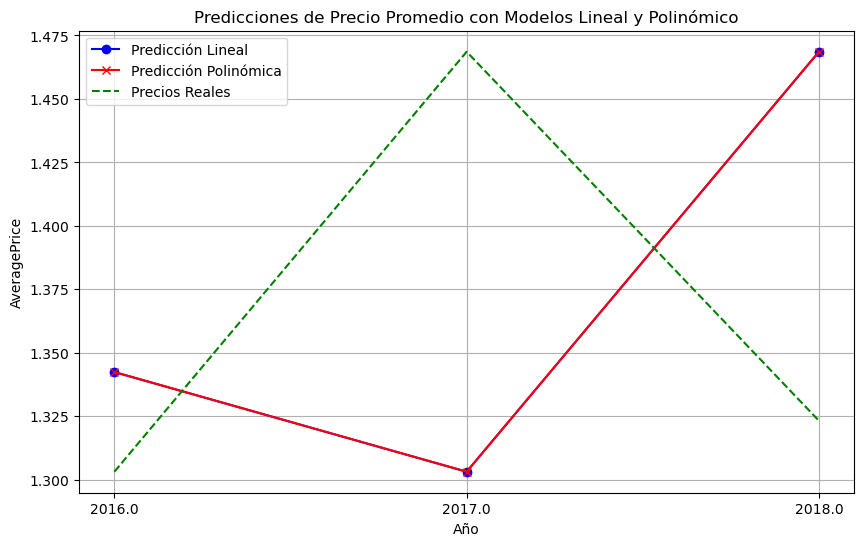

In [175]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Asegúrate de que 'data_avo' está definido correctamente y 'Date' está en formato datetime
data_avo['Date'] = pd.to_datetime(data_avo['Date'])

# Crear la columna 'Año'
data_avo['Año'] = data_avo['Date'].dt.year

# Filtrar solo las columnas numéricas y la columna 'Año'
numericas_df = data_avo.select_dtypes(include=['number'])
numericas_df['Año'] = data_avo['Año']

# Agrupar los datos por año y calcular el promedio de las columnas numéricas
df_anual = numericas_df.groupby('Año').mean().reset_index()

# Inicializamos las listas para almacenar los resultados
años = []
predicciones_lineales = []
predicciones_polinomicas = []
precios_actuales = []

# Ajuste y predicción con los modelos
for i in range(len(df_anual)-1):
    año_actual = df_anual.iloc[i]
    año_siguiente = df_anual.iloc[i+1]
    
    # Variable independiente (Año) y variable dependiente (AveragePrice)
    X_train = np.array([[año_actual['Año']]])  # Año actual como variable independiente
    y_train = año_actual['AveragePrice']  # Precio promedio del año actual como variable dependiente
    
    # Crear el modelo de regresión lineal
    model_linear = LinearRegression()
    model_linear.fit(X_train, [y_train])
    
    # Predecir el precio del siguiente año usando el modelo lineal
    prediccion_lineal = model_linear.predict([[año_actual['Año'] + 1]])[0]
    
    # Crear el modelo de regresión polinómica de grado 2
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, [y_train])
    
    # Predecir el precio del siguiente año usando el modelo polinómico
    X_test = np.array([[año_actual['Año'] + 1]])  # Año siguiente como valor para predecir
    X_test_poly = poly.transform(X_test)  # Aplicar la misma transformación polinómica
    prediccion_polinomica = model_poly.predict(X_test_poly)[0]
    
    # Almacenar las predicciones y precios reales
    predicciones_lineales.append(prediccion_lineal)
    predicciones_polinomicas.append(prediccion_polinomica)
    precios_actuales.append(año_siguiente['AveragePrice'])
    años.append(str(año_siguiente['Año']))

# Convertir las listas de predicciones y precios actuales a arrays
predicciones_lineales = np.array(predicciones_lineales)
predicciones_polinomicas = np.array(predicciones_polinomicas)
precios_actuales = np.array(precios_actuales)

# Evaluar el rendimiento del modelo con R^2 y RMSE para ambos modelos
r2_lineal = r2_score(precios_actuales, predicciones_lineales)
rmse_lineal = np.sqrt(mean_squared_error(precios_actuales, predicciones_lineales))

r2_polinomico = r2_score(precios_actuales, predicciones_polinomicas)
rmse_polinomico = np.sqrt(mean_squared_error(precios_actuales, predicciones_polinomicas))

# Mostrar las métricas de ambos modelos
print(f"Modelo Lineal - R^2: {r2_lineal}, RMSE: {rmse_lineal}")
print(f"Modelo Polinómico - R^2: {r2_polinomico}, RMSE: {rmse_polinomico}")

# Graficar los resultados
plt.figure(figsize=(10, 6))

# Gráfico de las predicciones de ambos modelos
plt.plot(años, predicciones_lineales, label='Predicción Lineal', color='blue', marker='o')
plt.plot(años, predicciones_polinomicas, label='Predicción Polinómica', color='red', marker='x')

# Graficar los precios reales
plt.plot(años, precios_actuales, label='Precios Reales', color='green', linestyle='--')

plt.xlabel('Año')
plt.ylabel('AveragePrice')
plt.title('Predicciones de Precio Promedio con Modelos Lineal y Polinómico')
plt.legend()
plt.grid(True)
plt.show()


6. **Desarrollo de Modelos de Regresión Múltiple:** 
   - **Uso de Datos:** Selecciona varias variables numéricas como `Total Volume`, `4046`, `4225`, `4770`, y `Total Bags` para predecir `AveragePrice`.
   - **Esperado:** 
     - Define las variables independientes (X) y dependientes (y).
     - Ajusta modelos de regresión múltiple.
     - Compara su rendimiento utilizando métricas como R² y RMSE y discute las implicaciones de los resultados.

In [65]:
data_avo = df.copy()
resultados = regresion_modelos(data_avo, ['Total Volume', '4046', '4225', '4770', 'Total Bags'], 'AveragePrice', modelo_tipo=3)

E:\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Modelo Lineal:
  R²: 0.5473
  RMSE: 0.2352
  Intercepto: 1.5911
  Coeficientes:
    Total Volume: -1.0346e-05
    4046: 1.0188e-05
    4225: 1.0265e-05
    4770: 9.8796e-06
    Total Bags: 1.0320e-05

Modelo Polinómico:
  R²: 0.5738
  RMSE: 0.2282
  Intercepto: 1.6049
  Coeficientes:
    1: 0.0000e+00
    Total Volume: 9.1637e-04
    4046: -9.1672e-04
    4225: -9.1659e-04
    4770: -9.1675e-04
    Total Bags: -9.1615e-04
    Total Volume^2: 4.1108e-08
    Total Volume 4046: -8.5790e-08
    Total Volume 4225: -8.1212e-08
    Total Volume 4770: 4.9863e-08
    Total Volume Total Bags: -9.1294e-08
    4046^2: 4.4683e-08
    4046 4225: 8.4788e-08
    4046 4770: -4.6288e-08
    4046 Total Bags: 9.4870e-08
    4225^2: 4.0105e-08
    4225 4770: -5.0866e-08
    4225 Total Bags: 9.0291e-08
    4770^2: -9.0972e-08
    4770 Total Bags: -4.0784e-08
    Total Bags^2: 5.0187e-08

Conclusiones:
  El modelo polinómico muestra un mejor ajuste a los datos, con un mayor R² y menor RMSE.
  Esto sugiere un

E:\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Implicaciones
-Habría que probar otras características que estén relacionadas con AveragePrice
-Interacciones entre variables o transformaciones que podrían mejorar el ajuste.
    -Podríamos crear una variable de interacción haciendo el producto de dos variables y añadirla al modelo
    -Podríamos aplicar transformaciones logaritmicas, polinómicas o normalizarlo
    
-Usar técnicas de selección de características para identificar las variables más relevantes.
    -Podríamos eliminar las variables con menor impacto
    -Seleccion hacia adelante, comenzar sin variables e ir agregando hasta que el modelo deje de cambiar significativamente
    -Regularizar con Lasso o Ridge

En resumen, el modelo polinómico parece ofrecer una ligera mejora sobre el modelo lineal en términos de ajuste y precisión.
Sin embargo, ambos modelos muestran que la relación entre las variables seleccionadas y el precio promedio puede ser más complicada y requerir 
una exploración más profunda para entender mejor los factores que influyen en AveragePrice.

7. **Análisis de Coeficientes de Regresión Múltiple:**
   - **Uso de Datos:** Examina los coeficientes de los modelos de regresión múltiple ajustados.
   - **Esperado:** 
     - Extrae los coeficientes del modelo ajustado.
     - Interpreta los coeficientes para entender el impacto de cada variable numérica en `AveragePrice`.
     - Comenta sobre las variables más significativas y su relevancia.

In [68]:
'''
Los coeficientes están en el anterior ejercicio
Vemos que aparece un valor de coeficinete muy pequeño, así que vamos a intentar aplicar un escalado a los datos para que las variables
tengan una media similar.  Esto debería hacer que los coeficientes se interpreten en una escala variable.
'''
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = data_avo[['Total Volume', '4046', '4225', '4770', 'Total Bags']]
y = data_avo['AveragePrice']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_avo[['Total Volume', '4046', '4225', '4770', 'Total Bags']])
y = data_avo['AveragePrice']

# Ajustar el modelo escalado
linear_model = LinearRegression()
linear_model.fit(X_scaled, y)

# Obtener los coeficientes en la escala estandarizada
coef_linear_scaled = pd.Series(linear_model.coef_, index=['Total Volume', '4046', '4225', '4770', 'Total Bags'])
print("Coeficientes del Modelo Lineal (escalado):")
print(coef_linear_scaled)

Coeficientes del Modelo Lineal (escalado):
Total Volume   -24.785723
4046            10.901144
4225             9.365150
4770             1.053264
Total Bags       7.458021
dtype: float64


In [69]:
#Modelo Polinómico de grado 2
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_scaled, y)

# Extracción de coeficientes para el modelo polinómico
poly_features = poly_model.named_steps['polynomialfeatures']
poly_coef = poly_model.named_steps['linearregression'].coef_

# Obtener nombres de las características polinómicas
poly_columns = poly_features.get_feature_names_out(X.columns)
coef_poly = pd.Series(poly_coef, index=poly_columns)
print("\nCoeficientes del Modelo Polinómico:")
print(coef_poly)


Coeficientes del Modelo Polinómico:
1                               0.000000
Total Volume                 2572.128784
4046                        -1149.061715
4225                         -979.632153
4770                         -114.409163
Total Bags                   -775.827713
Total Volume^2             235937.056551
Total Volume 4046         -219911.837146
Total Volume 4225         -177503.641024
Total Volume 4770           12735.558921
Total Volume Total Bags   -158062.037993
4046^2                      51154.808751
4046 4225                   82766.265137
4046 4770                   -5280.059622
4046 Total Bags             73357.797194
4225^2                      33380.466960
4225 4770                   -4947.386529
4225 Total Bags             59530.796696
4770^2                      -1033.955052
4770 Total Bags             -3142.238857
Total Bags^2                26210.897795
dtype: float64



Sabiendo que un coeficiente positivo significa que a medida que aumenta la variable AveragePrice tiende a aumentar y 
un coeficiente negativo según aumenta la variable, disminuye el AveragePrice.

Por ejemplo, Total Volume tiene un coeficiente positivo 2572.13, lo que sugiere que mayores volúmenes totales de venta se asocian con un incremento 
en el precio promedio,aunque este efecto debe evaluarse en conjunto con otros términos polinómicos.
Puntos a considerar:
-El coeficiente de Total Volume 4046 es negativo, lo que indica que la interacción entre Total Volume y 4046 tiene un efecto de disminución 
en AveragePrice.
-Las interacciones positivas como 4046 4225 sugieren que ciertos tipos de productos pueden influir de manera conjunta en el precio promedio.
-Los términos cuadráticos Total Volume^2, 4046^2... reflejan relaciones no lineales. Por ejemplo, Total Volume^2 tiene un coeficiente positivo bastante alto 235937.06, 
lo que puede indicar que un aumento en Total Volume tiene un efecto creciente en el AveragePrice, pero a un ritmo acelerado.


8. **Modelos de Regresión para Diferenciar Volúmenes de Ventas:**
   - **Uso de Datos:** Usa `AveragePrice`, `Total Volume`, `4046`, `4225`, y `4770`.
   - **Esperado:** 
     - Ajusta modelos de regresión para analizar cómo los diferentes volúmenes de ventas afectan `AveragePrice`.
     - Compara los resultados de regresión lineal y polinómica.
     - Presenta las conclusiones de tus análisis.

In [72]:
#modelo lineal
#Definir X e y
data_avo = df.copy()
data_avo['Date'] = pd.to_datetime(data_avo['Date'])
X = data_avo[['Total Volume', '4046', '4225', '4770']]
y = data_avo['AveragePrice']

# Ajuste del modelo lineal
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
linear_model = LinearRegression()
linear_model.fit(X_scaled, y)

# Predicciones y evaluación del modelo
y_pred_linear = linear_model.predict(X_scaled)
rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
r2_linear = r2_score(y, y_pred_linear)

print(f"Modelo Lineal - R²: {r2_linear}, RMSE: {rmse_linear}")


Modelo Lineal - R²: 0.5472658131833227, RMSE: 0.23521120732470197


In [73]:
# Crear el modelo polinómico
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X, y)

# Predicciones y evaluación del modelo polinómico
y_pred_poly = poly_model.predict(X)
rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
r2_poly = r2_score(y, y_pred_poly)

print(f"Modelo Polinómico - R²: {r2_poly}, RMSE: {rmse_poly}")

Modelo Polinómico - R²: 0.572637971840217, RMSE: 0.2285253232520478



Concluyo que ya que el modelo lineal y el polinómico tienen resultados similares, la relación entre el precio promedio y los volúmenes de ventas
puede ser lineal.  Esto indicaría que un cambio en el volumen de un tipo de producto impacta el precio promedio de manera proporcional y no 
depende de combinaciones o niveles de venta específicos.

De todas formas, un 0.57 sigue siendo bajo así que se podría ajustar el grado del polinomio, usar regularización, probar con otros modelos que 
pueden capturar relaciones complejas. También es fundamental trabajar en el preprocesamiento de los datos y la ingeniería de características.


9. **Análisis de la Influencia de las Ventas Totales en el Precio Promedio:**
   - **Uso de Datos:** Usa `Total Volume`, `AveragePrice`, y `Total Bags`.
   - **Esperado:** 
     - Ajusta un modelo de regresión lineal y polinómica para ver cómo varía `AveragePrice` en función del volumen total de ventas.
     - Evalúa la significancia de los coeficientes y discute su relevancia.

In [76]:
#modelo sin escalar

resultados = regresion_modelos(data_avo, ['Total Volume', 'Total Bags'], 'AveragePrice', modelo_tipo=3)


Modelo Lineal:
  R²: 0.5320
  RMSE: 0.2392
  Intercepto: 1.5953
  Coeficientes:
    Total Volume: -1.3563e-07
    Total Bags: 1.1134e-07

Modelo Polinómico:
  R²: 0.5492
  RMSE: 0.2347
  Intercepto: 1.6038
  Coeficientes:
    1: 0.0000e+00
    Total Volume: -2.8325e-07
    Total Bags: 5.0536e-07
    Total Volume^2: 2.3898e-14
    Total Volume Total Bags: -5.1652e-14
    Total Bags^2: -3.1878e-14

Conclusiones:
  El modelo polinómico muestra un mejor ajuste a los datos, con un mayor R² y menor RMSE.
  Esto sugiere una posible relación no lineal entre las variables independientes y el precio promedio.



E:\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
E:\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [77]:
# modelo escalado
X = data_avo[['Total Volume', 'Total Bags']]
y = data_avo['AveragePrice']

# Modelo de regresión lineal, probamos a escalar las variables independientes para ver si los resultados son mejores
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
linear_model = LinearRegression()
linear_model.fit(X_scaled, y)

# Realizar predicciones con el modelo lineal
y_pred_linear = linear_model.predict(X_scaled)

# Calcular métricas de evaluación
r2_linear = r2_score(y, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
print(f"Modelo Lineal - R²: {r2_linear}, RMSE: {rmse_linear}")


Modelo Lineal - R²: 0.5319570373743769, RMSE: 0.23915486829499627


In [78]:
# Crear y ajustar el modelo polinómico
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Realizar predicciones con el modelo polinómico
y_pred_poly = poly_model.predict(X_poly)

# Calcular métricas de evaluación
r2_poly = r2_score(y, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
print(f"Modelo Polinómico - R²: {r2_poly}, RMSE: {rmse_poly}")


Modelo Polinómico - R²: 0.5492070562038398, RMSE: 0.2347063938634596


In [79]:
# Coeficientes del modelo lineal
print("Coeficientes del Modelo Lineal:")
print(f"Intercepto: {linear_model.intercept_}")
for feature, coef in zip(['Total Volume', 'Total Bags'], linear_model.coef_):
    print(f"{feature}: {coef}")

Coeficientes del Modelo Lineal:
Intercepto: 1.3685687869822485
Total Volume: -0.32493986500966765
Total Bags: 0.0804624204163652


In [80]:
# Coeficientes del modelo polinómico
print("Coeficientes del Modelo Polinómico:")
print(f"Intercepto: {poly_model.intercept_}")
for feature, coef in zip(poly_features.get_feature_names_out(['Total Volume', 'Total Bags']), poly_model.coef_):
    print(f"{feature}: {coef}")


Coeficientes del Modelo Polinómico:
Intercepto: 1.6038072502881908
1: 0.0
Total Volume: -2.8325128508446554e-07
Total Bags: 5.053617990239962e-07
Total Volume^2: 2.3897704859961776e-14
Total Volume Total Bags: -5.1652072610453965e-14
Total Bags^2: -3.18778241511853e-14


Conclusiones
-Ambos modelos tienen valores de r2 y RMSE que indican que las variables Volumen Total y Bolsas no capturan completamente la variablidad en el precio promedio
-al haber poca diferencia entre las metricas de evaluacion de los dos modelos, el modelo lineal podría ser suficiente 
-podríamos incluir otras variables que influyan en AveragePrice para mejorar el modelo


10. **Regresión para Predecir el Precio Promedio Según el Volumen de Aguacates por Tipo:**
    - **Uso de Datos:** Usa `AveragePrice`, `4046`, `4225`, `4770`, y `Total Volume`.
    - **Esperado:** 
      - Ajusta modelos de regresión lineal y polinómica.
      - Evalúa la efectividad de ambos modelos utilizando métricas como R² y RMSE.
      - Discute cuál modelo ofrece mejores predicciones y por qué, basándote en los resultados obtenidos.


In [83]:
resultados = regresion_modelos(data_avo, ['Total Volume', '4046', '4225', '4770'], 'AveragePrice', modelo_tipo=3)
#print(formatear_resultados(resultados))

Modelo Lineal:
  R²: 0.5473
  RMSE: 0.2352
  Intercepto: 1.5909
  Coeficientes:
    Total Volume: -2.5871e-08
    4046: -1.3166e-07
    4225: -5.4722e-08
    4770: -4.4026e-07

Modelo Polinómico:
  R²: 0.5726
  RMSE: 0.2285
  Intercepto: 1.6039
  Coeficientes:
    1: 0.0000e+00
    Total Volume: 2.1545e-07
    4046: -5.6411e-07
    4225: -4.3689e-07
    4770: -5.8577e-07
    Total Volume^2: -4.6922e-14
    Total Volume 4046: 8.2543e-14
    Total Volume 4225: 9.6644e-14
    Total Volume 4770: -8.3162e-14
    4046^2: -2.2080e-15
    4046 4225: -4.5890e-14
    4046 4770: 3.4055e-13
    4225^2: -2.7040e-14
    4225 4770: 1.5744e-13
    4770^2: -6.3715e-13

Conclusiones:
  El modelo polinómico muestra un mejor ajuste a los datos, con un mayor R² y menor RMSE.
  Esto sugiere una posible relación no lineal entre las variables independientes y el precio promedio.



E:\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
E:\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [84]:

'''Regresión para Predecir el Precio Promedio Según el Volumen de Aguacates por Tipo:

Uso de Datos: Usa Average Price, 4046, 4225, 4770, y Total Volume.
Esperado:
Ajusta modelos de regresión lineal y polinómica.
Evalúa la efectividad de ambos modelos utilizando métricas como R² y RMSE.
Discute cuál modelo ofrece mejores predicciones y por qué, basándote en los resultados obtenidos.
'''
resultados = regresion_modelos(df, ['Total Volume', '4046','4225','4770'], 'AveragePrice', modelo_tipo=3)

Modelo Lineal:
  R²: 0.5473
  RMSE: 0.2352
  Intercepto: 1.5909
  Coeficientes:
    Total Volume: -2.5871e-08
    4046: -1.3166e-07
    4225: -5.4722e-08
    4770: -4.4026e-07

Modelo Polinómico:
  R²: 0.5726
  RMSE: 0.2285
  Intercepto: 1.6039
  Coeficientes:
    1: 0.0000e+00
    Total Volume: 2.1545e-07
    4046: -5.6411e-07
    4225: -4.3689e-07
    4770: -5.8577e-07
    Total Volume^2: -4.6922e-14
    Total Volume 4046: 8.2543e-14
    Total Volume 4225: 9.6644e-14
    Total Volume 4770: -8.3162e-14
    4046^2: -2.2080e-15
    4046 4225: -4.5890e-14
    4046 4770: 3.4055e-13
    4225^2: -2.7040e-14
    4225 4770: 1.5744e-13
    4770^2: -6.3715e-13

Conclusiones:
  El modelo polinómico muestra un mejor ajuste a los datos, con un mayor R² y menor RMSE.
  Esto sugiere una posible relación no lineal entre las variables independientes y el precio promedio.



E:\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
E:\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
